# 0. IMPORTS

## 0.1. Importing libraries

In [1]:
!pip install xgboost
!pip install Boruta

In [2]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import xgboost as xgb
import seaborn as sns
import datetime

from scipy                 import stats as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib            import pyplot as plt

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.2. Loading data

In [3]:
# Importar os datasets
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)

# Unir os datasetes
df_raw = df_store_raw.merge(df_sales_raw, how='inner', on='Store')

## 0.3. Helper functions

In [4]:
# Função para deixar gráficos pré-configurado
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
# Função de subplots de histogramas do matplotlib
def plot_hist_subplot(dataframe, n_rows, title, column, bins=30, color='midnightblue'):
    ax = fig.add_subplot(n_rows, 3, i+1)
    ax.hist(dataframe[column], bins=bins, color=color)
    ax.set_title(title, fontsize=20)
#   ax.set_xlabel(column, fontsize=15)

# Função para renomear as colunas do dataframe
def rename_columns(cols):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace( " ", "" )
    cols = list(map( title, cols ))
    cols = list(map( spaces, cols )) 
    cols = list(map( snakecase, cols ))
    return cols   

# Função que encoda variáveis categóricas
def dummies(df_aux, variable):
  df_aux = pd.get_dummies(df_aux, prefix=variable, columns=[variable])
  return df_aux

# Função para fazer o heatmap de variáveis categóricas
def cramer_v( x, y ):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / (min (kcorr-1, rcorr-1)) )

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

# Função das métricas de performance dos modelos de machine learning
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# Função cross-validation de performance dos modelos de machine learning
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('KFold Number: {}'.format(k))

        # Data inicial e fim para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrar dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation dataset
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1( yvalidation ), np.expm1( yhat ))

        # Guarda a performance de cada iteração kfold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model  Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [5]:
jupyter_settings();

# 1. PASSO 01 - DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
df1.columns = rename_columns( df1.columns )

## 1.2. Data Dimensions

In [8]:
print('Number of rows: {:,}'.format( df1.shape[0] ))
print('Number of columns: {:,}'.format( df1.shape[1] ))

Number of rows: 1,017,209
Number of columns: 18


## 1.3. Data Types

In [9]:
df1.dtypes

store                             int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
dtype: object

## 1.4. Check  NA's

In [10]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 1.5. Fillout NA's

In [11]:
# Alterar o tipo 'date' para datetime para usar na função lambda abaixo
df1['date'] = pd.to_datetime( df1['date'] )

# 'competition_distance': distância em metros até a loja concorrente mais próxima
# --> Número de NA's: 2,642.
# --> Preencher com uma distância grande para indicar que não há concorrência próxima.
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000.0 
                                                                 if math.isnan(x) else x )

# 'competition_open_since_month': o mês aproximado da hora em que o concorrente mais próximo foi aberto
# --> Número de NA's: 323,348.
# --> Preencher com o mês da coluna 'date'.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                 if math.isnan(x['competition_open_since_month']) 
                                                 else x['competition_open_since_month'], axis=1 )

# 'competition_open_since_year': o ano aproximado da hora em que o concorrente mais próximo foi aberto
# --> Número de NA's: 323,348.
# --> Preencher com o ano da coluna 'date'.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1 )

# 'promo2_since_week': descreve a semana do calendário em que a loja começou a participar do Promo2
# --> Número de NA's: 508,031.
# --> Preencher com a semana da coluna 'date'.
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week
                                       if math.isnan(x['promo2_since_week'])
                                       else x['promo2_since_week'], axis=1 ) 

# 'promo2_since_year': descreve o ano em que a loja começou a participar do Promo2
# --> Número de NA's: 508,031.
# --> Preencher com o ano da coluna 'date'
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year
                                      if math.isnan(x['promo2_since_year'])
                                      else x['promo2_since_year'], axis=1)

# 'promo_interval': descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente.
# --> Número de NA's: 508,031.
# --> Preencher com 0's.
df1['promo_interval'].fillna( 0, inplace=True )

## 1.6. Change Data Types

In [12]:
# Alterar os tipos de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 1.7. Descriptive Statics

In [13]:
num_attributes = df1.select_dtypes( include = ['int64', 'int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical attributes

In [14]:
# Tendência central (mean and median) 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Medidas de dispersão (min, max, range, std, skew and kurtosis)
d1 = pd.DataFrame( num_attributes.apply( min ) ).T 
d2 = pd.DataFrame( num_attributes.apply( max ) ).T 
d3 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d4 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# Concatenar
m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
2,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
3,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304
4,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
5,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310057,0.178723,-1.184046
6,promo2_since_year,2009.0,2015.0,6.0,2012.793297,2013.0,1.662657,-0.784436,-0.210075
7,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
8,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
9,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773


### 1.7.2. Categorical  attributes

In [15]:
# Número de conteúdos únicos das variáveis categóricas
cat_attributes.apply( lambda x: x.nunique() )

store_type        4
assortment        3
promo_interval    4
state_holiday     4
dtype: int64

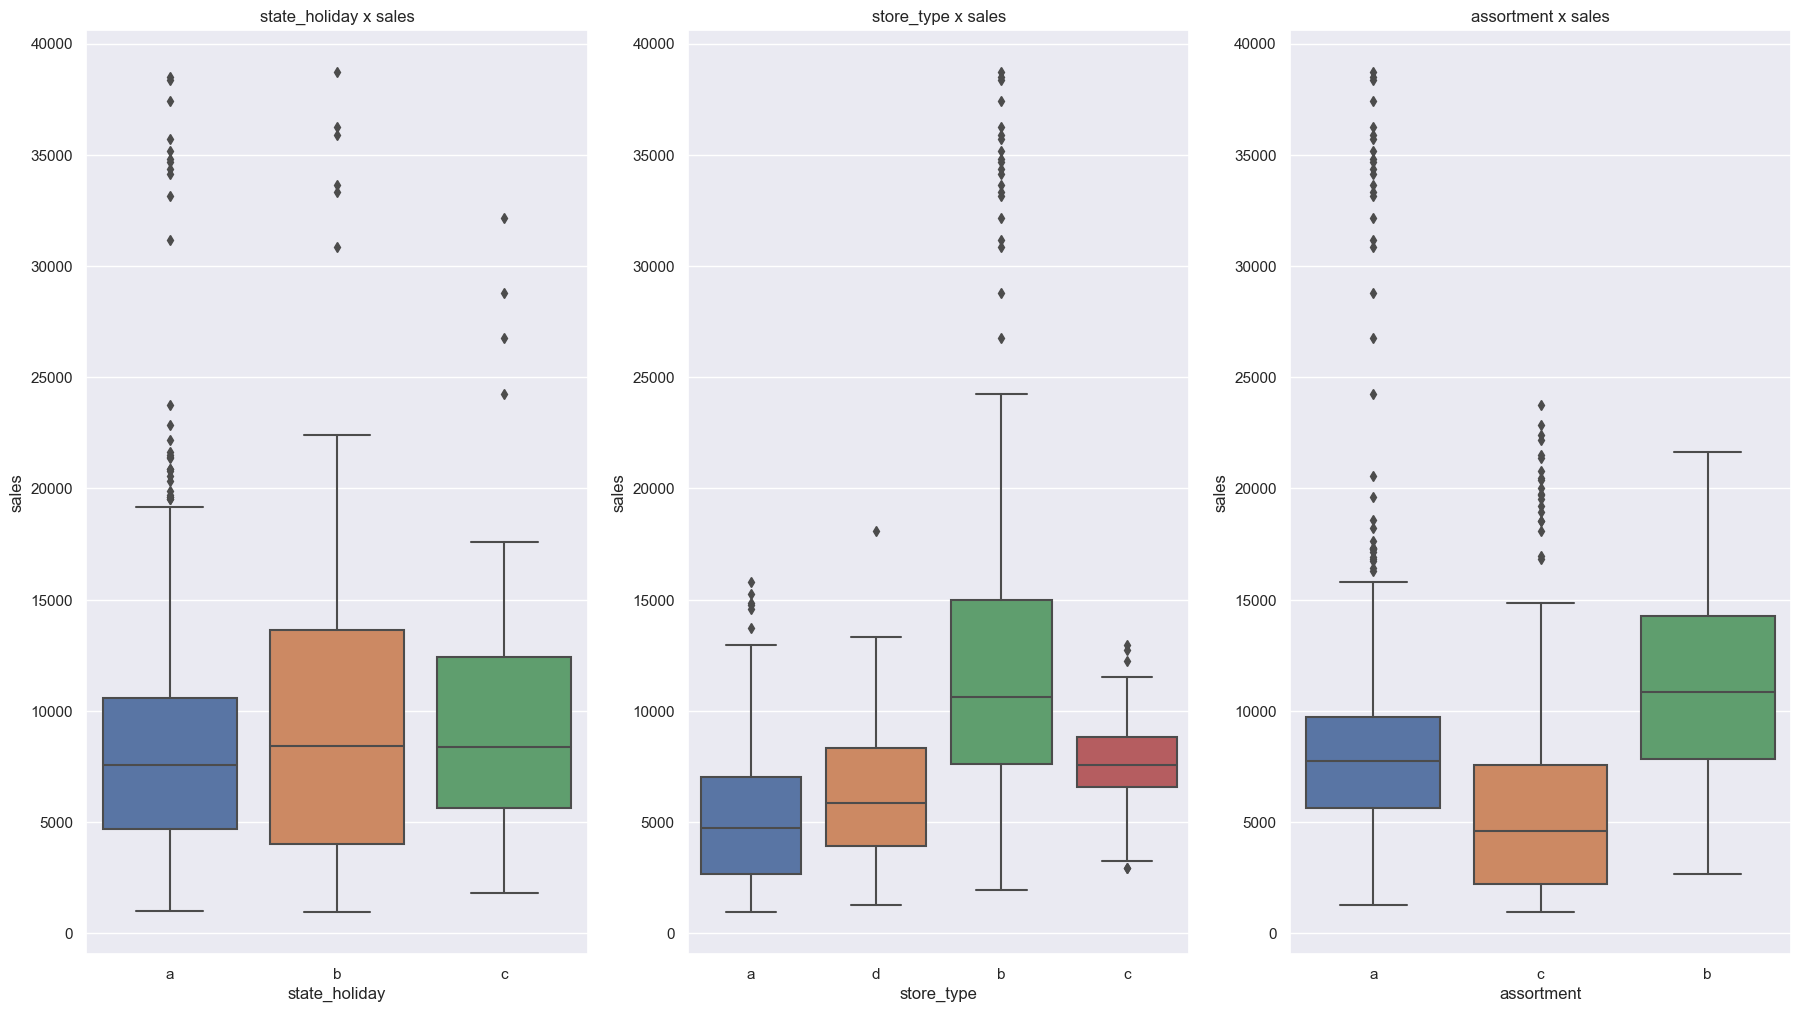

In [16]:
# Filtrar dados que não era feriado estadual e houve vendas
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Criar uma figura com 3 subplots e define o tamanho
fig, axs = plt.subplots( 1, 3, figsize=(22, 12) )

# Plotar 'state_holiday' x 'sales' filtrado
sns.boxplot( x='state_holiday', y='sales', data=aux, ax=axs[0] )
axs[0].set_title( 'state_holiday x sales' )

# Plotar 'store_type' x 'sales' filtrado
sns.boxplot( x='store_type', y='sales', data=aux, ax=axs[1] )
axs[1].set_title( 'store_type x sales' )

# Plotar 'assortment' x 'sales' filtrado
sns.boxplot( x='assortment', y='sales', data=aux, ax=axs[2] )
axs[2].set_title( 'assortment x sales' )

# Mostra o gráfico
plt.show()

# 2. PASSO 02 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

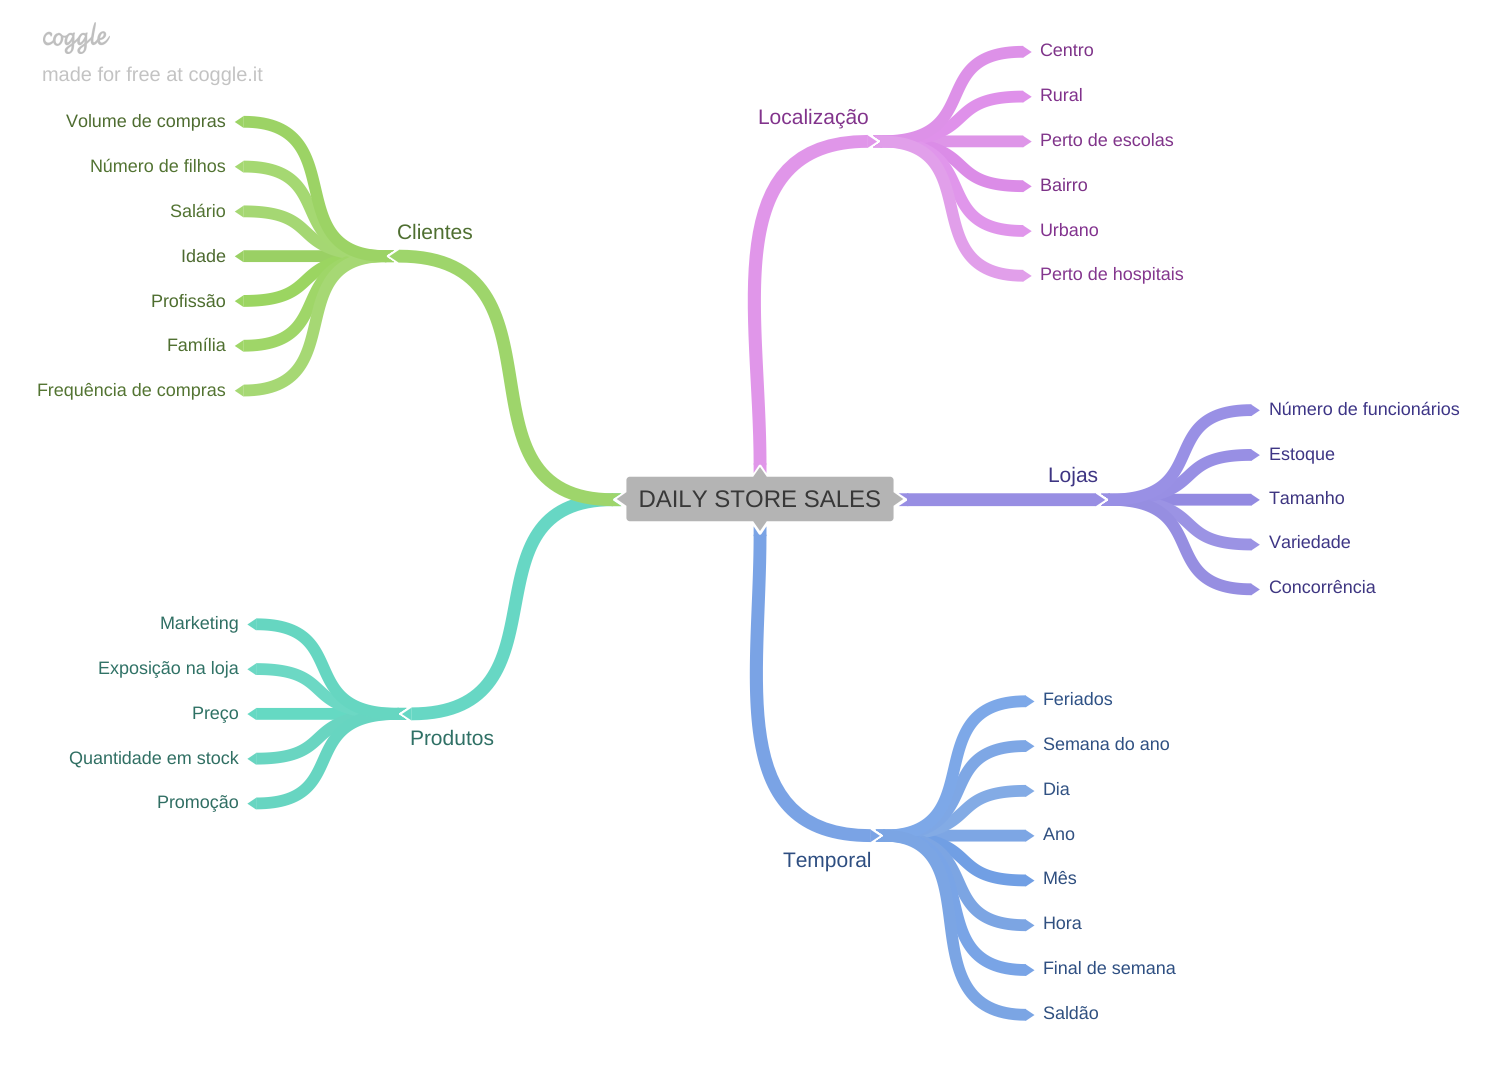

In [18]:
Image('../img/mind_map.png')

## 2.2. Criação das Hipóteses

### 2.2.1. Hipóteses Lojas

**HL1.** O dia da semana que mais vende é sábado

**HL2.** As lojas de tipo 'a' têm mais vendas

**HL3.** Quanto mais variedades, mais vendas

### 2.2.2. Hipóteses Feriados

**HF1.** Há mais vendas nos feriados estaduais

**HF2.** Há mais vendas nos feriados escolares

### 2.2.3. Hipóteses Promoções

**HP1.** Quanto mais promoções eventuais, mais vendas

**HP2.** Quanto mais promoções contínuas, mais vendas

**HP3.** Quanto mais tempo de promoção, mais vendas

**HP4.** Quanto menor o intervalo entre as promoções, mais vendas

### 2.2.4. Hipóteses Concorrência

**HC1.** Quanto maior a distância da concorrência, mais vendas

**HC2.** Após abertura de concorrência, as vendas diminuem

## 2.3. Lista Final de Hipóteses

**HL1.** O dia da semana que mais vende é sábado

**HL2.** As lojas de tipo 'a' têm mais vendas

**HL3.** Quanto mais variedades, mais vendas

**HF1.** Há mais vendas nos feriados estaduais

**HF2.** Há mais vendas nos feriados escolares

**HP1.** Quanto mais promoções eventuais, mais vendas

**HP2.** Quanto mais promoções contínuas, mais vendas

**HP3.** Quanto mais tempo de promoção, mais vendas

**HP4.** Quanto menor o intervalo entre as promoções, mais vendas

**HC1.** Quanto maior a distância da concorrência, mais vendas

**HC2.** Após abertura de concorrência, as vendas diminuem

## 2.4. Feature Engineering

### 2.4.1. Converter

In [19]:
# Converter os códigos de 'state_holiday' em nome (a: public_holiday, b: easter_holiday, c: christmas, 0: regular_day)
state_holiday_rename = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_rename)

# Converter os códigos de 'assortment' em nível de variedades de produtos (a: basic, b: extra, c: extended)
assortment_rename = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_rename)

### 2.4.2. Criar

In [20]:
# 'year': ano de venda
df2['year'] = df2['date'].dt.year

# 'month': mês de venda
df2['month'] = df2['date'].dt.month

# 'day': day de venda
df2['day'] = df2['date'].dt.day

# 'week_of_year': semana de venda do ano
df2['week_of_year'] = df2['date'].dt.weekofyear

# 'year_week': semana de venda do ano, no formato string 'YYYY-WW'
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# 'competition_time_month': Quantidade de meses desde que a concorrência abriu até a data de venda
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                   month=x['competition_open_since_month'],
                                                                   day=1 ), axis=1 )
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30 ).apply( lambda x: x.days ).astype( int )

# promo2_since: Data de início da promo2
df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# promo2_time_week: Quantidade de semanas desde o início da promo2 até a data de venda
df2['promo2_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# 3. PASSO 03 - FILTRAGEM DE VARIÁVEIS

## 3.1. Filtragem das Linhas

In [21]:
# Filtrar apenas lojas abertas e com vendas
df3 = df2.loc[( df2['open'] != 0 ) & ( df2['sales'] > 0 ), :].reset_index(drop=True)

In [22]:
print('Number of rows: {:,}'.format(df3.shape[0]))
print('Number of columns: {:,}'.format(df3.shape[1]))

Number of rows: 844,338
Number of columns: 27


## 3.2. Seleção das Colunas

In [23]:
# Remover colunas que não serão utilizadas
# --> 'customers': Remover, pois precisaríamos ter a previsão da quantidade de clientes em cada loja nas próximas seis semanas.
# --> 'open': Remover, pois já selecionamos somente lojas abertas.
# --> 'promo_interval'

cols_drop = ['customers', 'open', 'promo_interval']
df3 = df3.drop( cols_drop, axis=1 )

In [24]:
num_attributes = df3.select_dtypes( include = ['int64', 'int32', 'float64'] )
cat_attributes = df3.select_dtypes( exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'] )

# 4. PASSO 04 - EXPLORATORY DATA ANALYSIS (EDA)

- Como as variáveis impactam o fenômeno?
- Qual é a força deste impacto? 
- Validação de hipóteses de negócio e geração de insights;
- Perceber variáveis que são importantes para o modelo.

In [25]:
df4 = df3.copy()

## 4.1. Análise Univariada
- Como são as variáveis? (min, max, distribuição, range etc)

Feature | Description | Content
-- | -- | --
store | a unique Id for each store | unique for each one (1,115)
store_type | differentiates between 4 different store models | a, b, c, d
assortment | describes an assortment level | a: basic, b: extra, c: extended
competition_distance | distance in meters to the nearest competitor store | min: 20.0 m, max: 75,860.0 
competition_open_since_month | gives the approximate month of the time the nearest competitor was opened | from 1 to 12
competition_open_since_year | gives the approximate year of the time the nearest competitor was opened | min: 1900, max: 2015
promo2 | a continuing and consecutive promotion for some stores | 0: store is not participating, 1: store is participating
promo2_since_week | describes the calendar week when the store started participating in Promo2 | from 1 to 50
promo2_since_year | describes the year when the store started participating in Promo2 | min: 2009, _max: 2015
promo_interval | describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. | Month's names: ['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']
day_of_week | day of week | from 1 to 7
date | date of sale | min: 2013-01-01, max: 2015-07-31
sales | the turnover for any given day | (this is what you are predicting)
customers | the number of customers on a given day | min: 0, max: 7,388
open | an indicator for whether the store was open | 0: closed, 1: open
promo | indicates whether a store is running a promo on that day | 0: no, 1: yes
state_holiday | indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends |  a: public holiday, b: Easter holiday, c: Christmas, 0: None
school_holiday | indicates if the (Store, Date) was affected by the closure of public schools | 0: closed, 1: open

### 4.1.1. Response Variable

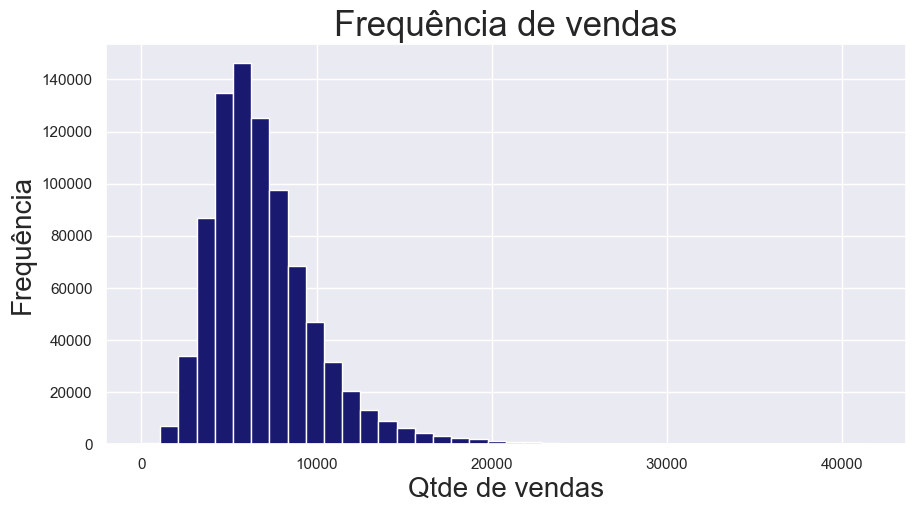

In [26]:
# Cria o gráfico
fig = plt.figure( figsize = (8, 4))
ax = fig.add_axes([0, 0, 1, 1])

# Configura o título e os eixos
ax.set_title('Frequência de vendas', fontsize=25)
ax.set_xlabel('Qtde de vendas', fontsize=20)
ax.set_ylabel('Frequência', fontsize=20)

# Plota e mostra o gráfico
ax.hist( df4['sales'], bins=40, color='midnightblue')
plt.show()

### 4.1.2. Numerical Variable

**CONCLUSÕES**

- competition_distance: A maioria da concorrência está perto, a aproximadamente 5km de distância.
- promo: As promoções pontuais são relativamente muitas.
- promo2: As promoções contínuas são tão frequentes quanto os dias normais.
- day_of_week: O domingo é muito menos frequente do que os demais dias.
- customers: A quantidade mais comum de clientes por dia nas lojas é entre 300 a 1,000.
- school_holiday: Os feriados escolares têm uma frequência relevante.
- state_holiday: Todos os feriados juntos representam 1% do total, o que as torna irrelevantes.
- assortment: O tipo de variedade 'extra' é muito menos frequente do que a básica e a estendida, talvez seja o caso de juntá-la a estendida para formarmos uma de 'sim' ou 'não'.

In [27]:
num_attributes.columns

Index(['store', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'year', 'month', 'day', 'week_of_year', 'competition_time_month',
       'promo2_time_week'],
      dtype='object')

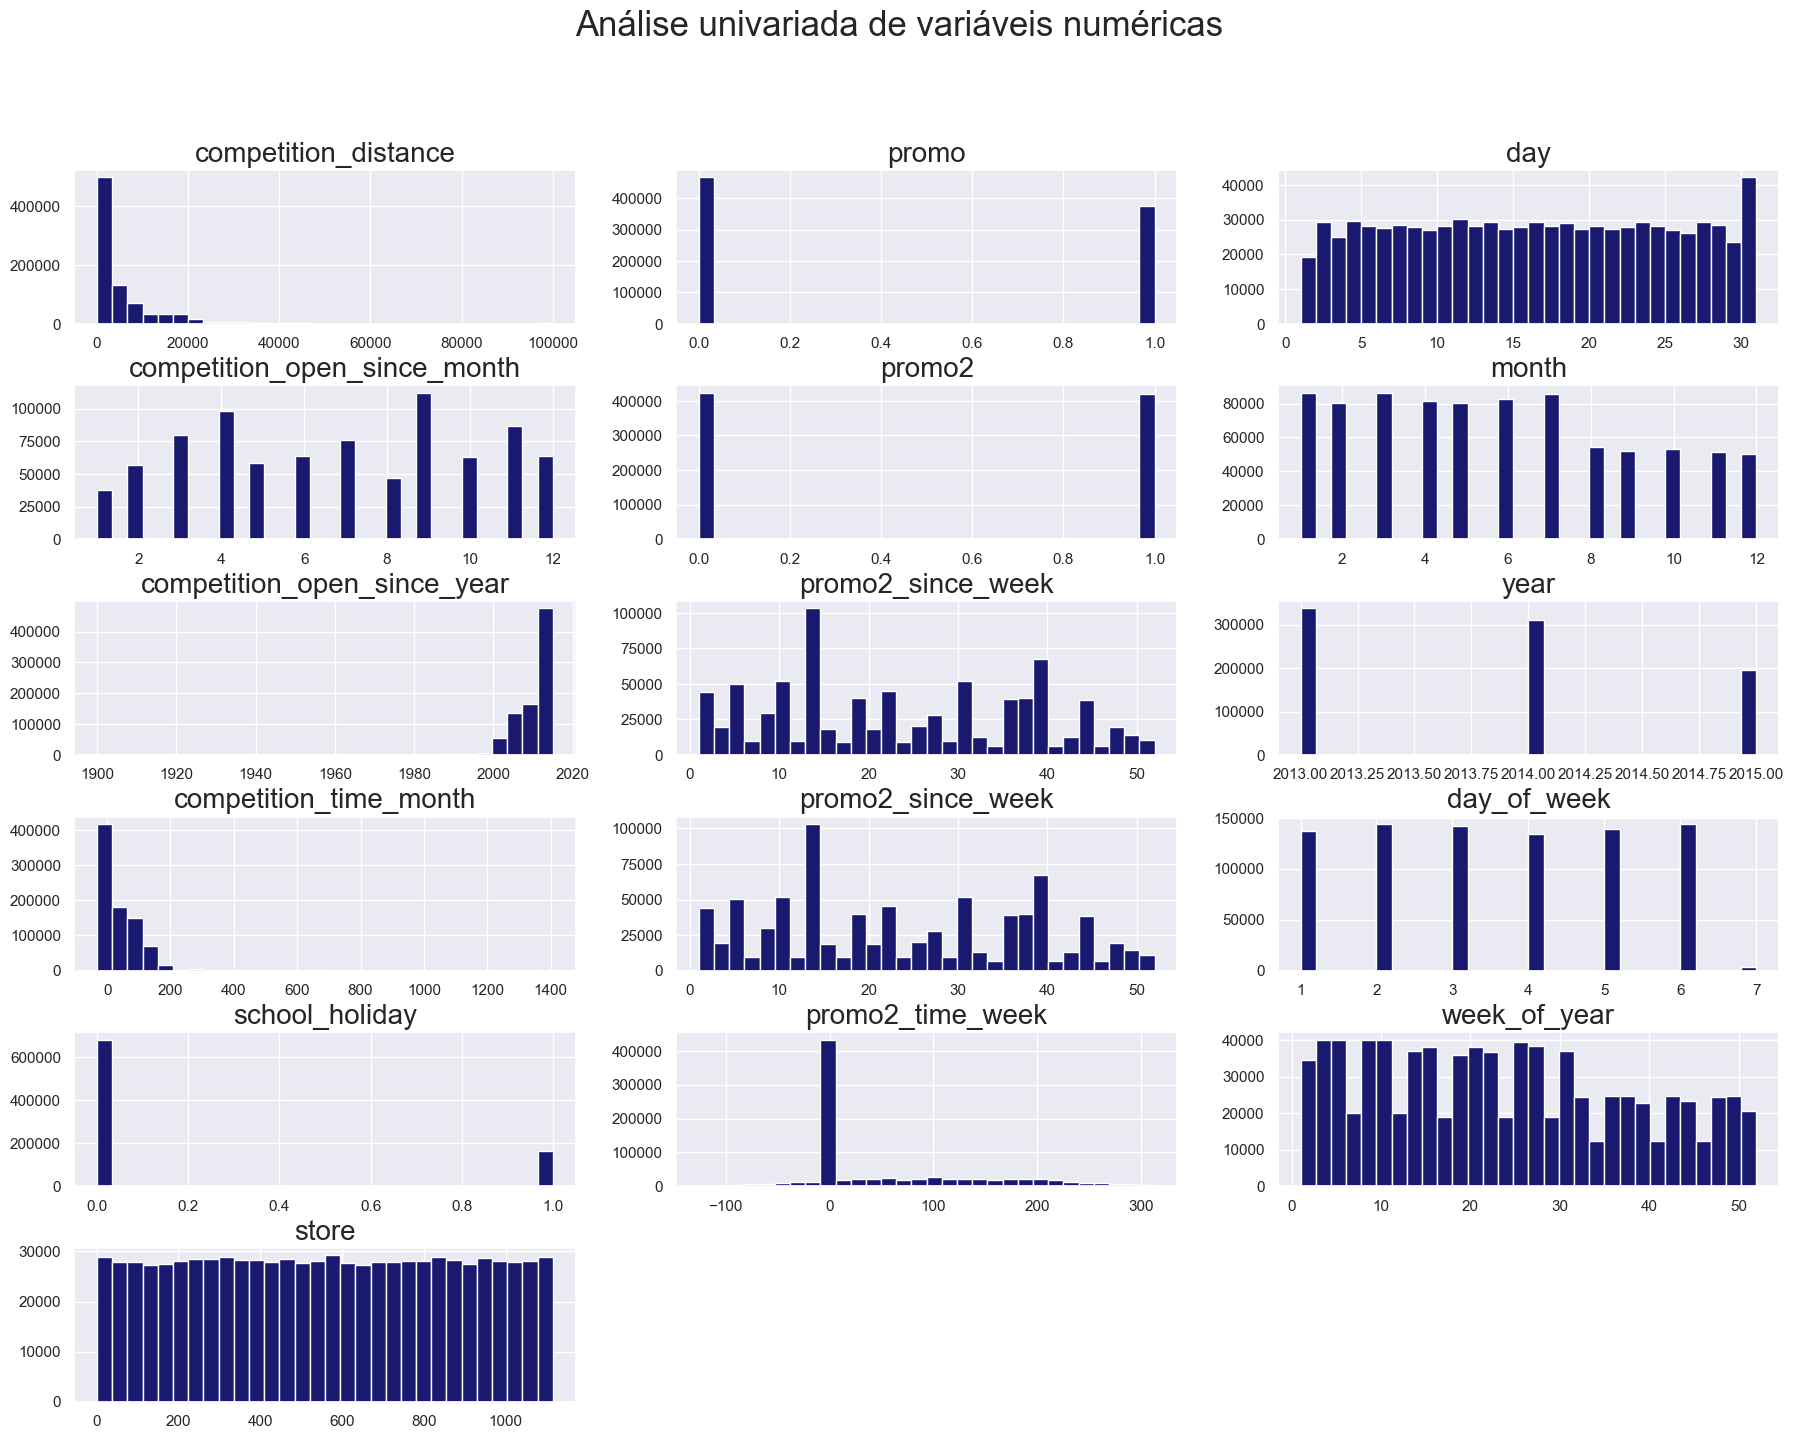

In [28]:
# Cria o gráfico
fig = plt.figure(figsize=(22, 16))
fig.suptitle('Análise univariada de variáveis numéricas', fontsize=25)

# Define as colunas que queremos plotar
columns = [ 'competition_distance', 'promo', 'day',
            'competition_open_since_month', 'promo2', 'month',
            'competition_open_since_year', 'promo2_since_week', 'year',
            'competition_time_month', 'promo2_since_week', 'day_of_week',
            'school_holiday', 'promo2_time_week', 'week_of_year',
            'store']

# Cria os subplots
n_columns = 3
n_rows = math.ceil(len(columns) / n_columns)
for i, col in enumerate(columns):
    plot_hist_subplot(df4, n_rows, col, col)

# Adiciona espaço vertical entre os subplots
fig.subplots_adjust(hspace=0.4)

# Mostra o gráfico
plt.show()

### 4.1.3. Categorical Variable

In [29]:
cat_attributes.columns

Index(['store_type', 'assortment', 'state_holiday', 'year_week'], dtype='object')

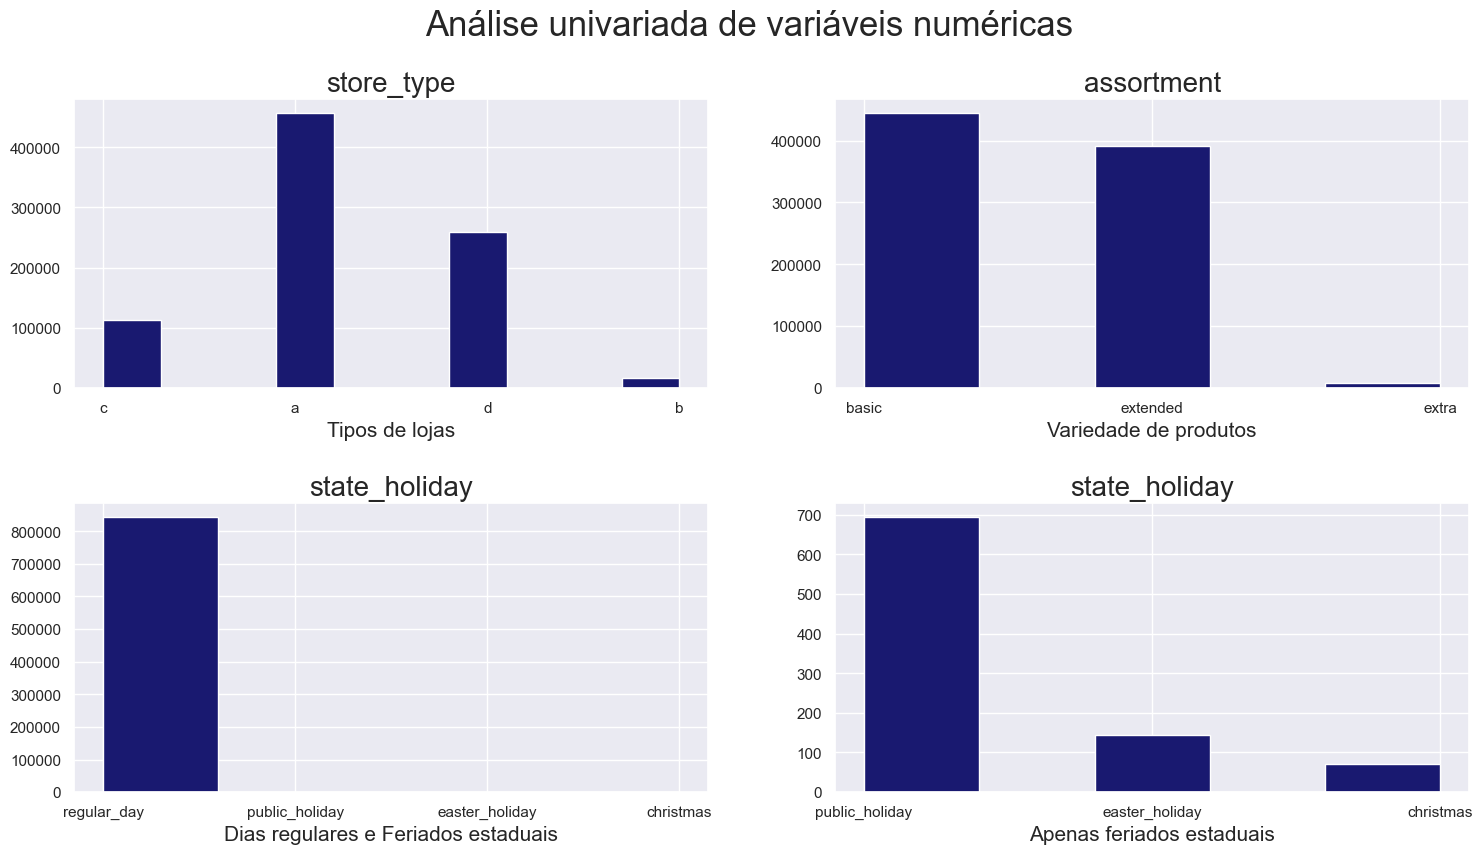

In [30]:
# Cria o gráfico
fig = plt.figure( figsize = (18, 9))

# Configura o título
fig.suptitle('Análise univariada de variáveis numéricas', fontsize=25)
cor = 'midnightblue'

# Adiciona o primeiro subplot
ax1 = fig.add_subplot(2, 2, 1)
ax1.hist(df4['store_type'], bins=10, color=cor)
ax1.set_title('store_type', fontsize=20)
ax1.set_xlabel('Tipos de lojas', fontsize=15)

# Adiciona o segundo subplot
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(df4['assortment'], bins=5, color=cor)
ax2.set_title('assortment', fontsize=20)
ax2.set_xlabel('Variedade de produtos', fontsize=15)

# Adiciona o terceiro subplot
ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(df4['state_holiday'], bins=5, color=cor)
ax3.set_title('state_holiday', fontsize=20)
ax3.set_xlabel('Dias regulares e Feriados estaduais', fontsize=15)

# Adiciona o quarto subplot
aux = df4[df4['state_holiday'] != 'regular_day']
ax4 = fig.add_subplot(2, 2, 4)
ax4.hist(aux['state_holiday'], bins=5, color=cor)
ax4.set_title('state_holiday', fontsize=20)
ax4.set_xlabel('Apenas feriados estaduais', fontsize=15)

# Adiciona espaço vertical entre os subplots
fig.subplots_adjust(hspace=0.4)

# Plota e mostra o gráfico
plt.show()

## 4.2. Análise Bivariada
- Como a variável impacta no fenômeno? (Validação das hipóteses)
- Qual a força deste impacto?

### HL1. O dia da semana que mais vende é sábado
**FALSO:** SEGUNDA é o dia com MAIOR nº de vendas.

**SUGESTÃO DE MELHORIA:** No futuro, separar dias regulares e feriados para análise. 

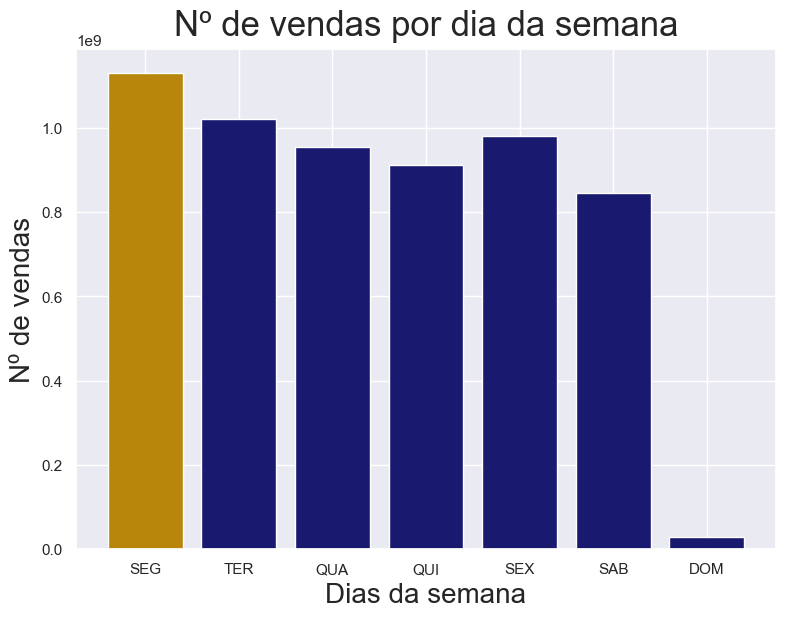

In [31]:
# Filtra e agrupa
vendas_por_dia_da_semana = df4.groupby('day_of_week')['sales'].sum().reset_index()

# Converte os códigos de 'day_of_week' em nomes de dias da semana
# --> Por se tratar de uma empresa europeia, o primeiro dia é a segunda-feira
day_of_week_rename = {1:'SEG', 2:'TER', 3:'QUA', 4:'QUI', 5:'SEX', 6:'SAB', 7:'DOM'}
vendas_por_dia_da_semana['day_of_week'] = vendas_por_dia_da_semana['day_of_week'].map(day_of_week_rename)

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*7
max_sales_idx = np.argmax(vendas_por_dia_da_semana['sales'])
colors[max_sales_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('Nº de vendas por dia da semana', fontsize=25, pad=10)
ax.set_xlabel('Dias da semana', fontsize=20)
ax.set_ylabel('Nº de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(vendas_por_dia_da_semana['day_of_week'], vendas_por_dia_da_semana['sales'], color=colors)
plt.show()

### HL2. As lojas de tipo 'a' têm mais vendas
**VERDADE:** As lojas do tipo 'A' têm MAIOR quantidade de vendas

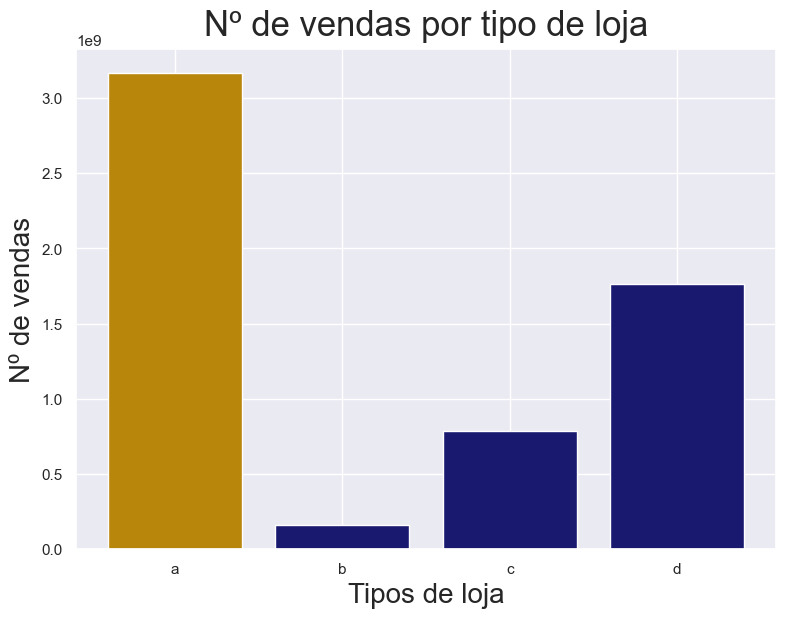

In [32]:
# Filtra e agrupa
df_aux = df4.groupby('store_type')['sales'].sum().reset_index()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
colors = ['midnightblue']*4
max_sales_idx = np.argmax(df_aux['sales'])
colors[max_sales_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('Nº de vendas por tipo de loja', fontsize=25, pad=10)
ax.set_xlabel('Tipos de loja', fontsize=20)
ax.set_ylabel('Nº de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['store_type'], df_aux['sales'], color=colors)
plt.show()

### HL3. Quanto mais variedades, mais vendas
**FALSO:** As lojas com MAIOR variedade, vende MENOS.

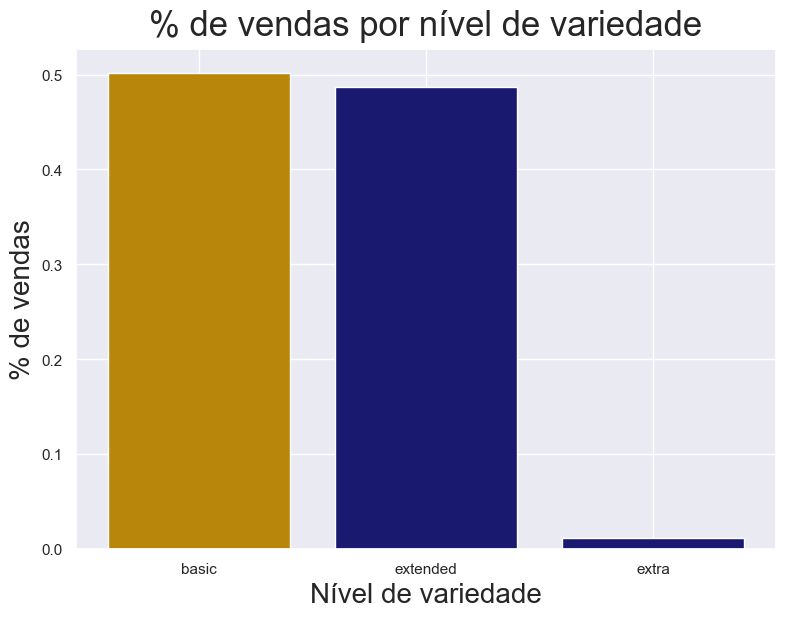

In [33]:
# Filtra e agrupa
df_aux = df4.loc[:, ['assortment', 'sales']].groupby('assortment').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas por nível de variedade', fontsize=25, pad=10)
ax.set_xlabel('Nível de variedade', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['assortment'], df_aux['prop'], color=colors)
plt.show()

<AxesSubplot: xlabel='year_week'>

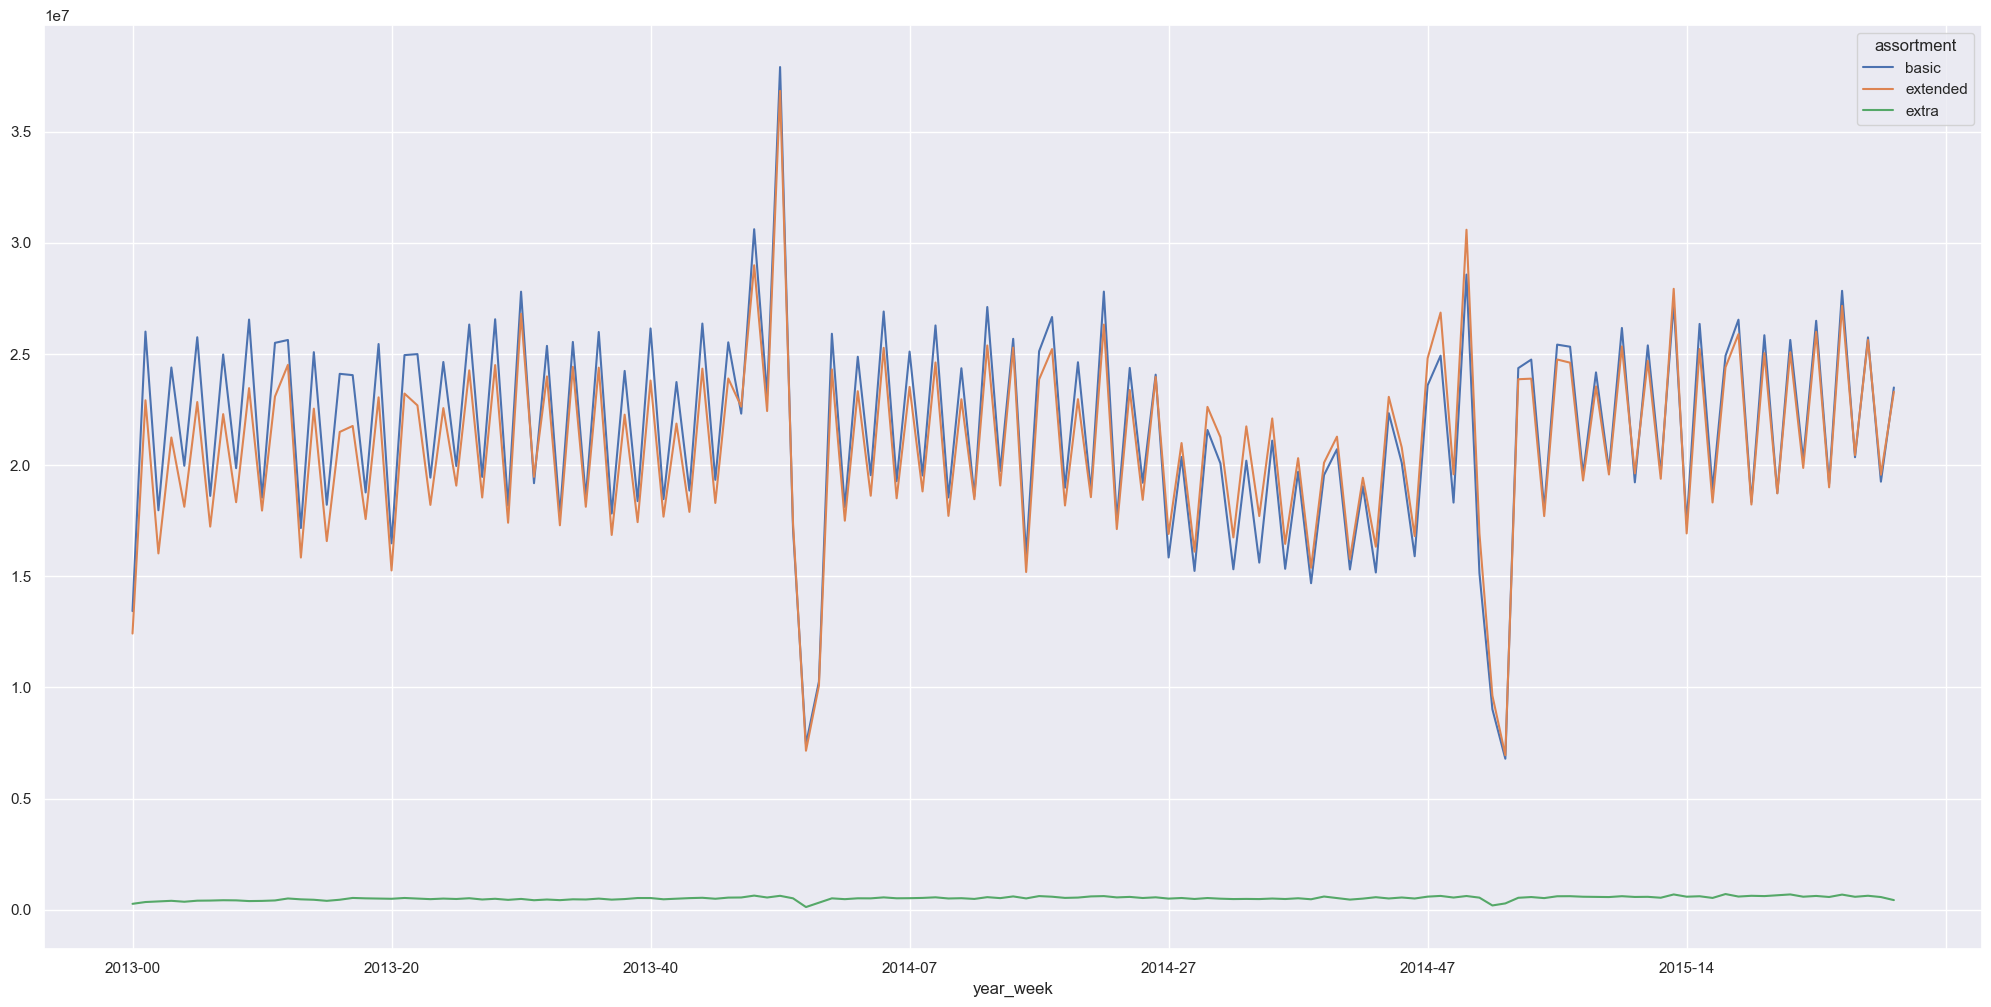

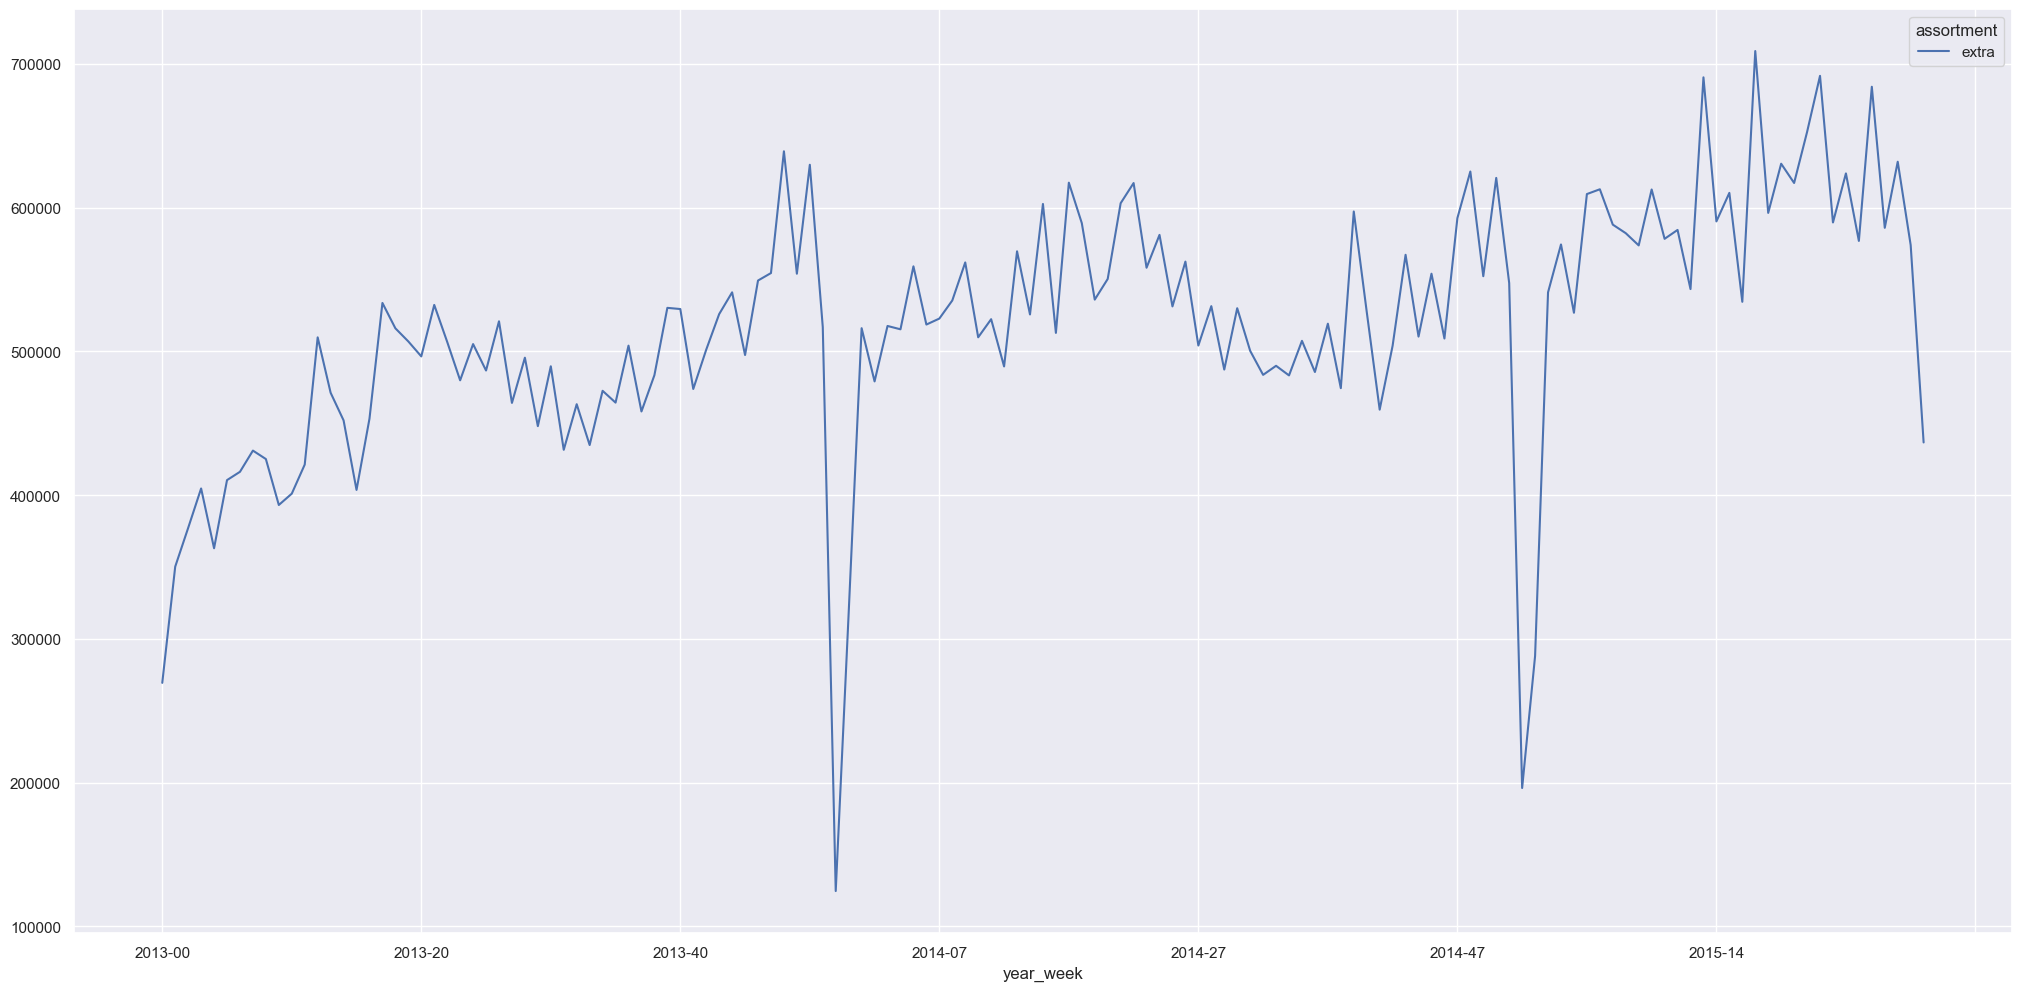

In [34]:
# Plota um gráfico com o comportamento temporal dos diferentes tipos de assortment ao longo das semanas
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns='assortment', values='sales').plot()

# Plota um gráfico com o comportamento temporal apenas do assortment do tipo 'extra' ao longo das semanas
aux2 = aux1[aux1['assortment'] == 'extra']
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

### HF1. Há mais vendas nos feriados estaduais
**FALSO:** Nos feriados estaduais, a quantidade de vendas é MENOR.

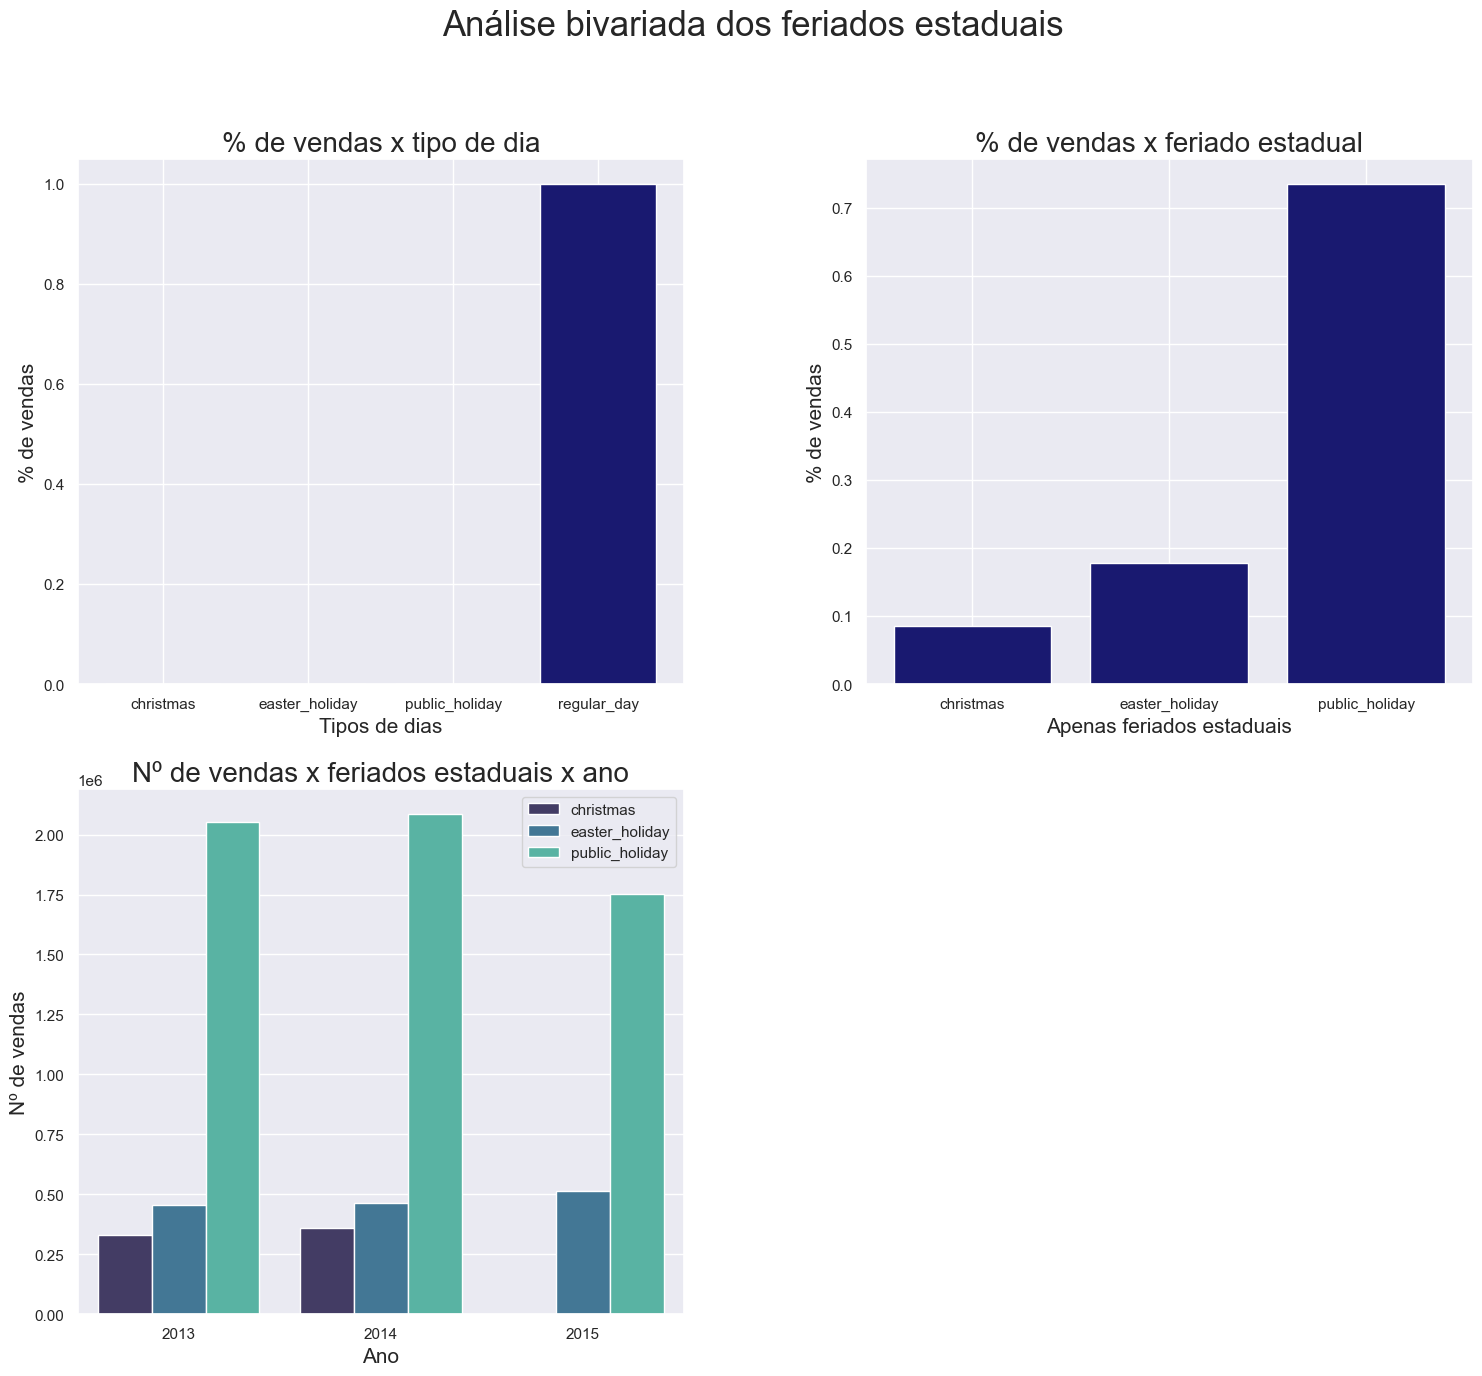

In [35]:
# Cria o gráfico
fig = plt.figure(figsize=(18, 15))

# Configura o título
fig.suptitle('Análise bivariada dos feriados estaduais', fontsize=25)
cor = 'midnightblue'

# Adiciona o primeiro subplot
aux1 = df4.loc[:, ['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux1['prop'] = aux1['sales'] / aux1['sales'].sum()
ax1 = fig.add_subplot(2, 2, 1)
ax1.bar(aux1['state_holiday'], aux1['prop'], color=cor)
ax1.set_title('% de vendas x tipo de dia', fontsize=20)
ax1.set_xlabel('Tipos de dias', fontsize=15)
ax1.set_ylabel('% de vendas', fontsize=15)

# Adiciona o segundo subplot
aux2 = df4.loc[df4['state_holiday'] != 'regular_day', ['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2['prop'] = aux2['sales'] / aux2['sales'].sum()
ax2 = fig.add_subplot(2, 2, 2)
ax2.bar(aux2['state_holiday'], aux2['prop'], color=cor)
ax2.set_title('% de vendas x feriado estadual', fontsize=20)
ax2.set_xlabel('Apenas feriados estaduais', fontsize=15)
ax2.set_ylabel('% de vendas', fontsize=15)

# Adiciona o terceiro subplot
aux3 = df4.loc[df4['state_holiday'] != 'regular_day', ['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
ax3 = fig.add_subplot(2, 2, 3)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3, ax=ax3, palette='mako')
ax3.legend(loc='upper right')
ax3.set_title('Nº de vendas x feriados estaduais x ano', fontsize=20)
ax3.set_xlabel('Ano', fontsize=15)
ax3.set_ylabel('Nº de vendas', fontsize=15)

# Ajusta o espaço entre os subplots
fig.subplots_adjust(wspace=0.3)

# Plota e mostra o gráfico
plt.show()

### HF2. Há mais vendas nos feriados escolares
**FALSO:** Nos feriados escolares, a quantidade de vendas é MENOR.

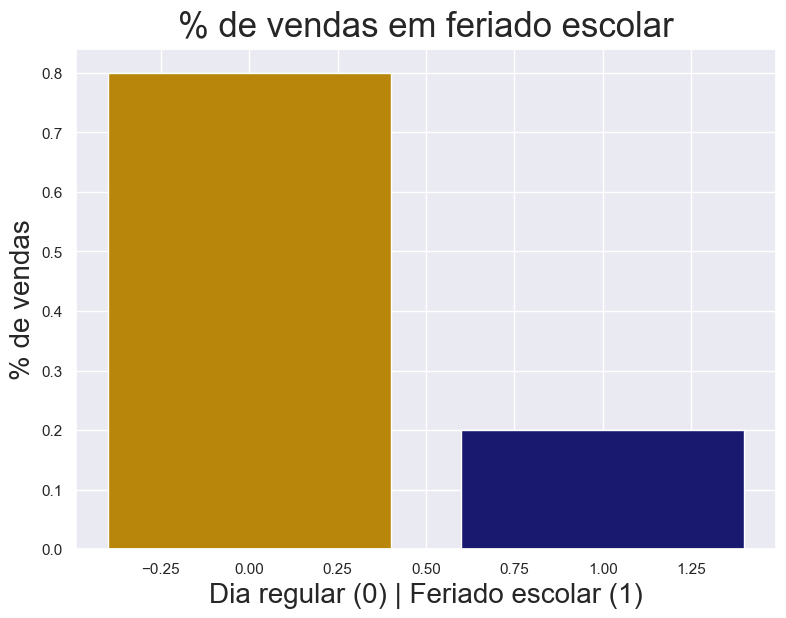

In [36]:
# Filtra e agrupa
df_aux = df4.loc[:, ['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas em feriado escolar', fontsize=25, pad=10)
ax.set_xlabel('Dia regular (0) | Feriado escolar (1)', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['school_holiday'], df_aux['prop'], color=colors)
plt.show()

### HP1. Em dias de promoções tradicionais, as vendas aumentam
**VERDADE:** Em dias de promoções 

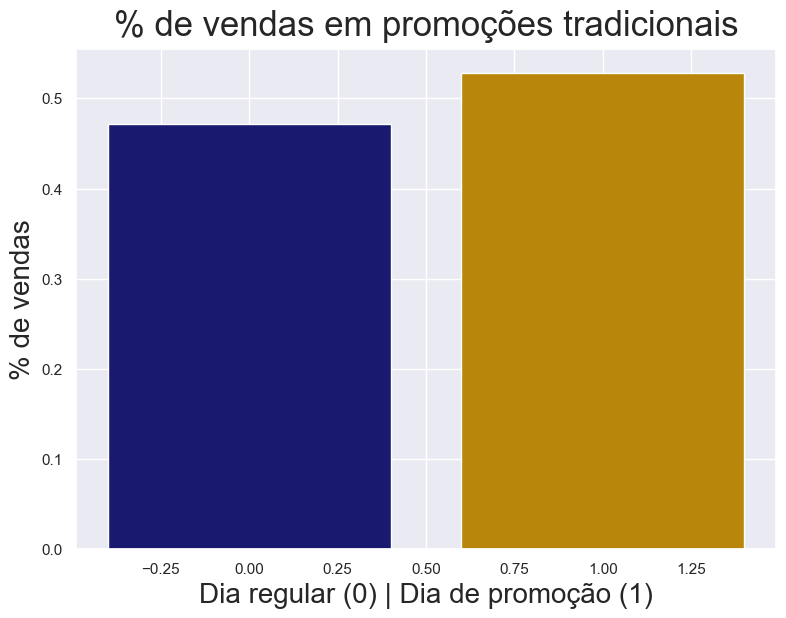

In [37]:
# Faz a soma de vendas
df_aux = df4.loc[:, ['promo', 'sales']].groupby('promo').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas em promoções tradicionais', fontsize=25, pad=10)
ax.set_xlabel('Dia regular (0) | Dia de promoção (1)', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['promo'], df_aux['prop'], color=colors)
plt.show()

### HP2. Quanto mais promoções contínuas, mais vendas
**FALSO:**

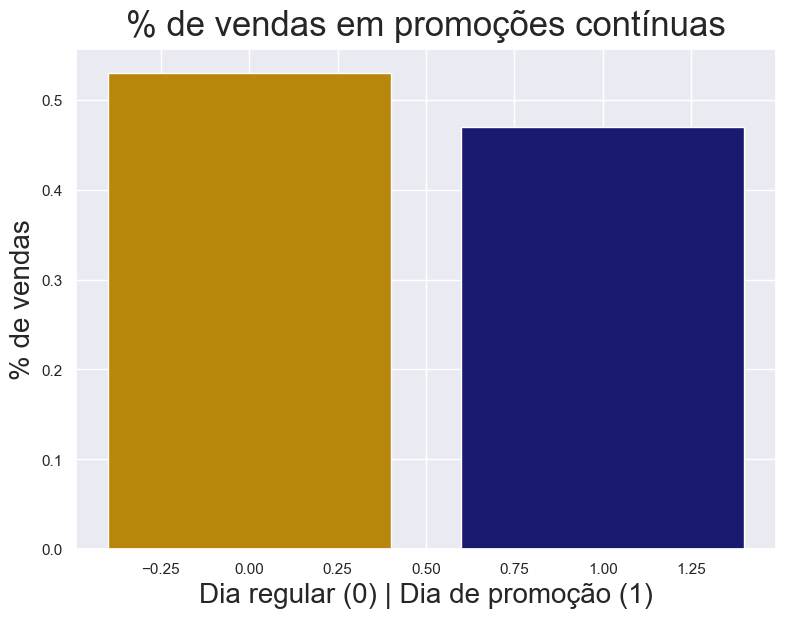

In [38]:
# Faz a soma de vendas
df_aux = df4.loc[:, ['promo2', 'sales']].groupby('promo2').sum().reset_index()
df_aux['prop'] = df_aux['sales'] / df_aux['sales'].sum()

# Cria o gráfico
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

# Define a lista de cores e destaca a maior
max_idx = df_aux['sales'].argmax()
colors = ['midnightblue'] * len(df_aux)
colors[max_idx] = 'darkgoldenrod'

# Configura o título e os eixos
ax.set_title('% de vendas em promoções contínuas', fontsize=25, pad=10)
ax.set_xlabel('Dia regular (0) | Dia de promoção (1)', fontsize=20)
ax.set_ylabel('% de vendas', fontsize=20)

# Plota e mostra o gráfico
ax.bar(df_aux['promo2'], df_aux['prop'], color=colors)
plt.show()

### **HP3.** Quanto mais tempo de promoção, mais vendas
**FALSO:** Lojas com MAIS promoções consecutivas vendem MENOS.

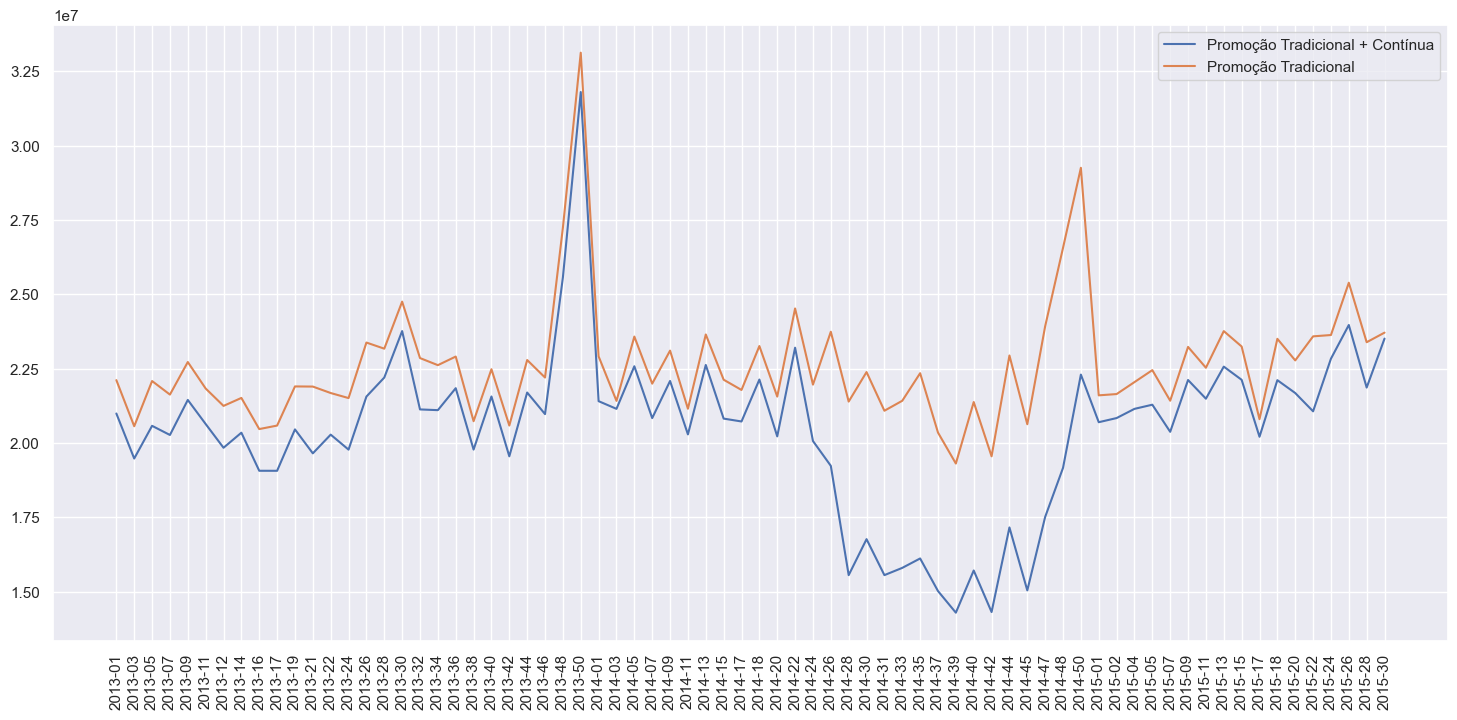

In [39]:
fig, ax = plt.subplots(figsize=(18, 8))

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax.plot(aux1['year_week'], aux1['sales'])

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax.plot(aux2['year_week'], aux2['sales'])

ax.legend(labels=['Promoção Tradicional + Contínua', 'Promoção Tradicional'])

# Configura a rotação dos labels do eixo x para 90 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

### <s>**HP4.** Quanto menor o intervalo entre as promoções, mais vendas</s>
**OBS.:** Será tratado no próximo ciclo CRISP.

### HC1. Quanto maior a distância da concorrência, mais vendas
**FALSO:** Quanto MAIOR a distância da concorrência, MENOR as vendas.

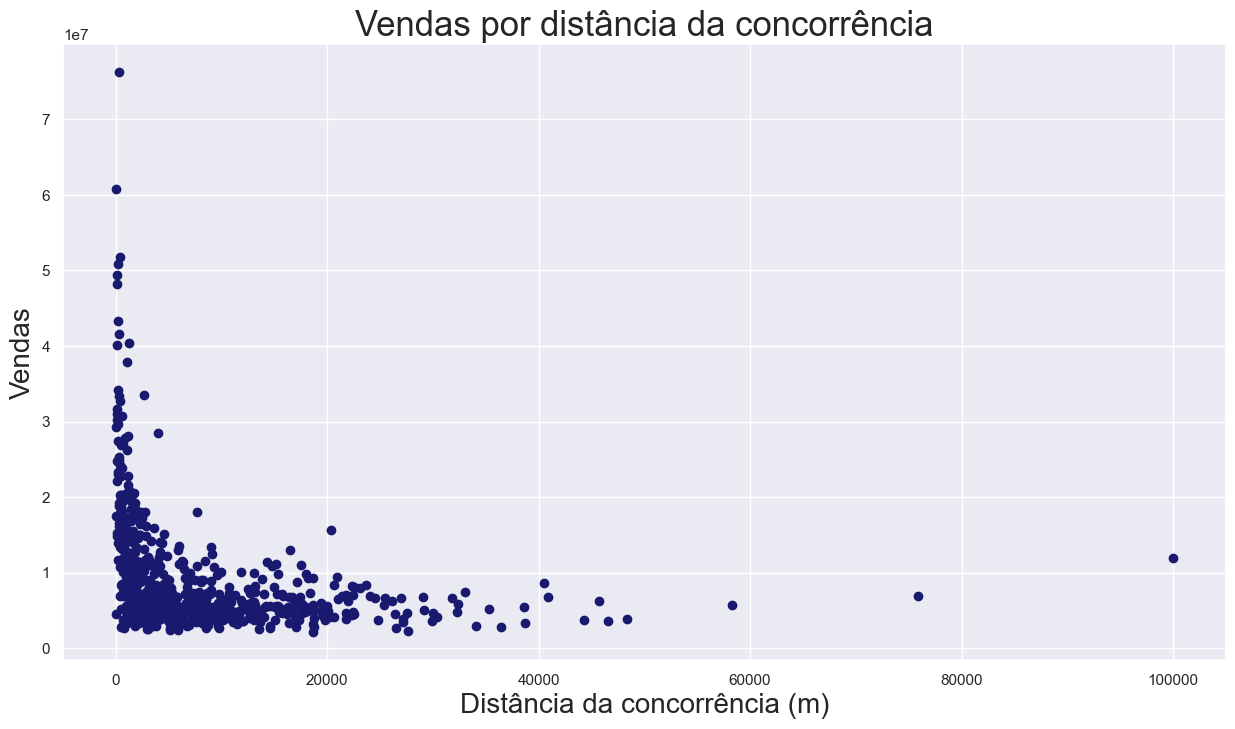

In [40]:
# Faz a soma de vendas por distância da concorrência
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Cria e plota o gráfico
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.scatter(x='competition_distance',  y='sales', data=aux, color='midnightblue')

# Define o título e as labels dos eixos
ax.set_title('Vendas por distância da concorrência', fontsize=25)
ax.set_xlabel('Distância da concorrência (m)', fontsize=20)
ax.set_ylabel('Vendas', fontsize=20)

# Mostra o gráfico
plt.show()

### <s>**HC2.** Após abertura de concorr^6encia, as vendas diminuem</s>
**OBS.:** Será tratado no próximo ciclo CRISP.

## 4.3. Análise Multivariada
- Como as variáveis estão correlacionadas?
- Qual a força de correlação entre elas?
- Identificar e remover colunas que carregam o mesmo conteúdo de informação.

👉 É sempre bom lembrar que correlação não implica causalidade, só pq as variáveis estão correlacionadas não necessariamente uma causa a outra.

### 4.3.1. Numerical Attributes

In [41]:
num_attributes.columns

Index(['store', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'year', 'month', 'day', 'week_of_year', 'competition_time_month',
       'promo2_time_week'],
      dtype='object')

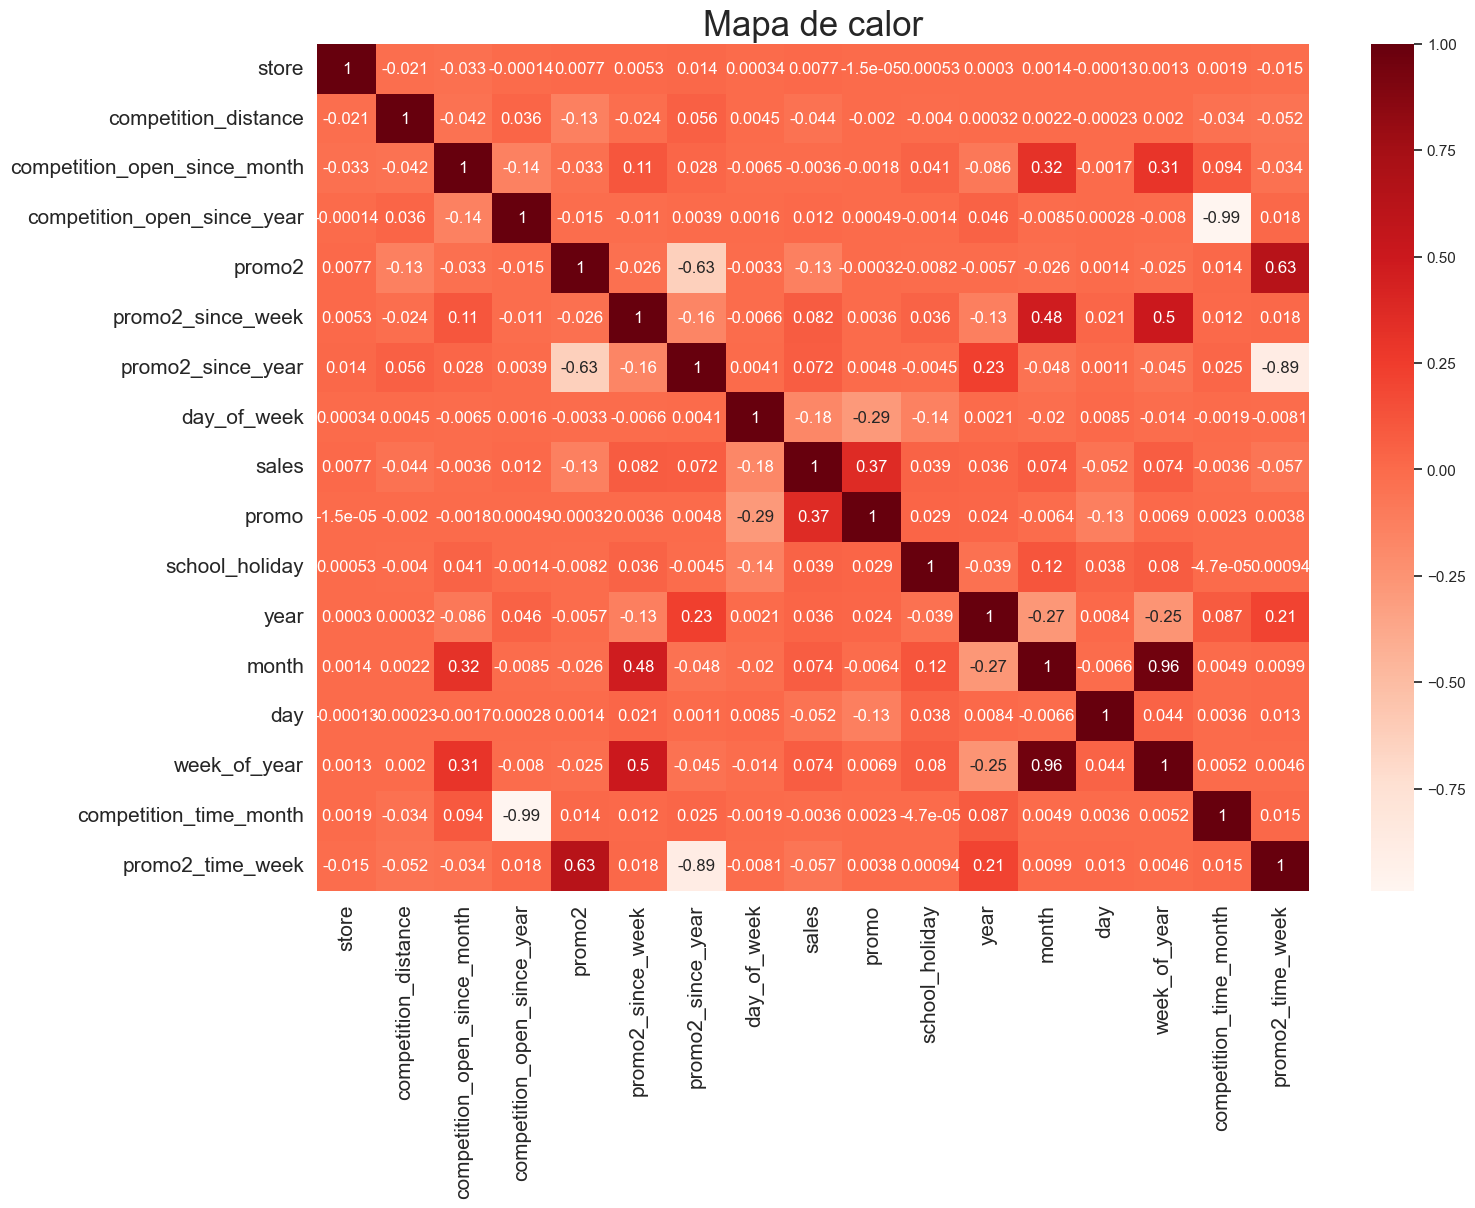

In [42]:
# Na correlação entre as variáveis, aquelas que mais afetam a quantidade de vendas são: 
# --> diretamente proporcionais: promo (37%)
# --> inversamente proporcionais: day_of_week ( -18% ) e promo2 (-13% )

# Criar o mapa de calor
corr = df4.corr(method='pearson')
fig, ax = plt.subplots(figsize=(16, 11))

# Configura o título e os eixos
ax.set_title('Mapa de calor', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

# Plota e mostra o gráfico
ax = sns.heatmap(corr, annot=True, cmap='Reds', ax=ax)
plt.show()

# SUGESTÕES: 
# --> Encodar os dias da semana com o mesmo peso (utilizando dummies), para entender melhor essa correlação.

### 4.3.2. Categorical Attributes

In [43]:
cat_attributes.columns

Index(['store_type', 'assortment', 'state_holiday', 'year_week'], dtype='object')

#### 4.3.2.2. V de Cramer

<AxesSubplot: >

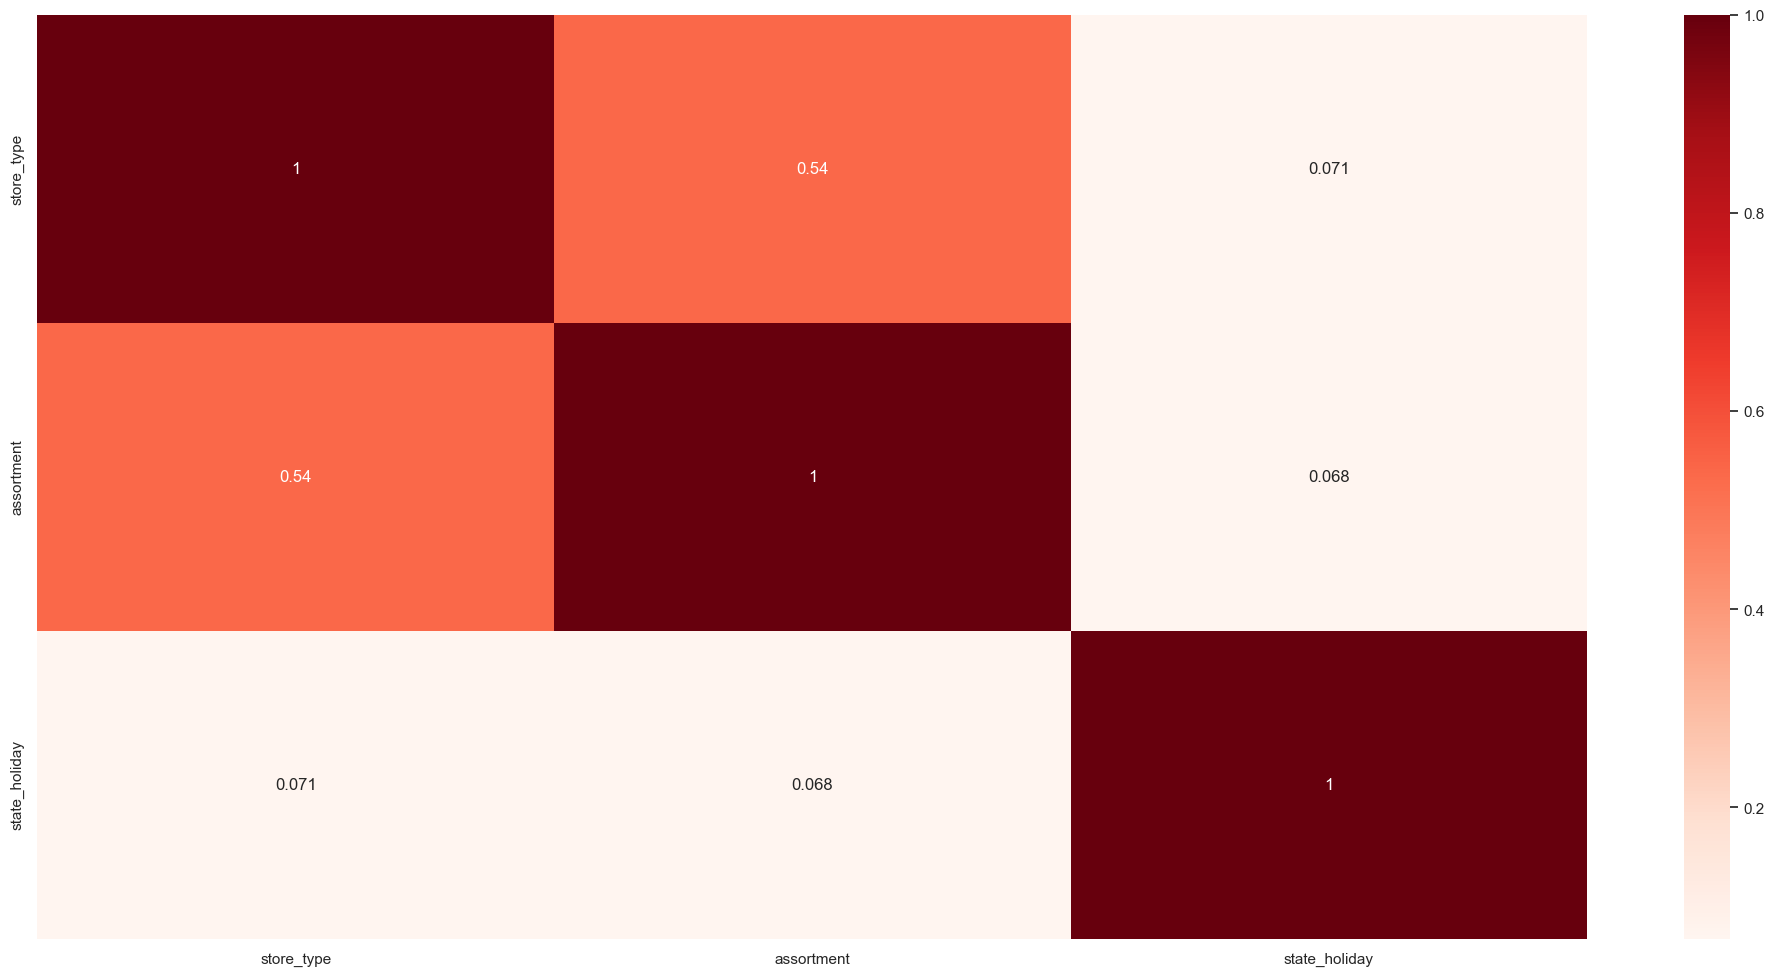

In [44]:
# Análise de correlação entre as variáveis
# --> Comprova que existe uma correlação forte entre 'assortment' e 'store_type'

# Apenas variáveis categóricos
a = cat_attributes.copy()

# Calcular V de Cramer
a1 = cramer_v(a['store_type'], a['store_type'])
a2 = cramer_v(a['store_type'], a['assortment'])
a3 = cramer_v(a['store_type'], a['state_holiday'])

a4 = cramer_v(a['assortment'], a['store_type'])
a5 = cramer_v(a['assortment'], a['assortment'])
a6 = cramer_v(a['assortment'], a['state_holiday'])

a7 = cramer_v(a['state_holiday'], a['store_type'])
a8 = cramer_v(a['state_holiday'], a['assortment'])
a9 = cramer_v(a['state_holiday'], a['state_holiday'])

#Final dataset
d = pd.DataFrame({'store_type': [a1, a2, a3],
                  'assortment': [a4, a5, a6],
                  'state_holiday': [a7, a8, a9]})
d = d.set_index(d.columns)

# Mostra o gráfico
sns.heatmap (d, annot=True, cmap='Reds')

# 5. PASSO 05  - DATA PREPARATION

1. Por que é importante?
- O aprendizado da maioria dos algoritmos de ML é facilitado com dados numéricos e na mesma escala.
- Encoding: Transformar as variáveis categóricas em numéricas;
- Normalização: Diminuir o grau de importância das variáveis com maior range.

- Normalização: 
    - Reescala o centro para 0 com desvio-padrão igual a 1;
    - Funciona melhor para features com distribuição normal.
- Rescaling: 
    - Reescala para o intervalo entre 0 e 1;
    - Distribuições não Gaussianas.
    
https://www.kaggle.com/code/discdiver/guide-to-scaling-and-standardizing/notebook
    
- Transformação:
    - Conversão de features categóricas para numéricas (encoding);
    - Transformação de natureza (ex.: natureza cíclica dos meses).

In [103]:
df5 = df4.copy()

## 5.1. Normalização

- X_norm = (Xi - mean(X)) / std(X)
- Reescala o centro para 0 com desvio-padrão igual a 1;
- Funciona melhor para features com distribuição normal (formato de sino e mean ~= median ~= mode)

In [46]:
# Não se aplica às features deste dateset.

## 5.2. Rescaling

- Min-Max Scaler:
    - X_norm = (Xi - X_min) / (X_max - X_min)
    - Ideal para features que não têm um range muito grande (outliers).
- Robust Scaler:
    - X_scaled = (Xi - Q2(X)) / (Q3(X) - Q1(X))
    - Ideal para features que possuem outliers.

In [105]:
rs = RobustScaler()
mms = MinMaxScaler()

# 'competition_distance'
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# 'competition_time_month'
df5['competition_time_month'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# 'promo2_time_week'
df5['promo2_time_week'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameter/promo2_time_week_scaler.pkl', 'wb'))

# 'year'
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Encoding

1. One Hot Encoding: 
- Cria variáveis dummy para cada categoria;
- É útil quando a variável categórica não tem ordem ou hierarquia e cada categoria tem um comportamento muito distinto;
- Exemplo: Feriados (pascoa, natal, dias normais etc).

2. Label Encoding: 
- Atribui um número aleatório para cada categoria;
- Pode ser útil quando os dados categóricos possuem uma ordem implícita;
- Exemplo: quando temos um conjunto de nomes de países em que precisamos codificar em valores numéricos para usá-los em um modelo de machine learning;
- Problema: é importante lembrar que o Label Encoding pode criar uma relação de ordem artificial entre as categorias que pode não ser representativa do problema real, o que pode afetar negativamente o desempenho do modelo de machine learning. Portanto, é importante avaliar cuidadosamente se a aplicação do Label Encoding é adequada para os dados em questão.

3. Ordinal Encoding: 
- É útil quando as categorias apresentam uma ordem natural;
- Exemplo: temperatura (very cold, cold, warm, hot, very hot), nível de educação ou nível de satisfação.

4. Target Encoding: 
- É útil quando você deseja codificar considerando sua relação com a variável resposta;
- Também pode ser útil quando você tem muitas categorias (mais de 10, por exemplo) e deseja reduzir o número de variáveis em seu modelo, mas ainda considerar a informação contida nas categorias em relação ao target;
- Exemplo: cores, temperatura, estado, cidade, países etc.

5. Frequency Encoding: 
- Substitui cada categoria pelo número de vezes que ela aparece no conjunto de dados;
- É útil quando a frequência de uma categoria está relacionada com a variável resposta;
- Pode ajudar a reduzir o impacto de categorias raras, que podem ter pouco valor informativo;
- Exemplo: Os mesmos do target enconding.

6. Embedding Encoding: 
- É um método de codificação de variáveis categóricas que é amplamente utilizado em problemas de processamento de linguagem natural (NLP) e aprendizado de máquina (ML) em geral. Ele é uma técnica de codificação implícita que mapeia cada categoria em um espaço vetorial multidimensional, tentando manter a distância entre as representações das categorias dentro de um contexto;
- Em outras palavras, o Embedding Encoding é útil quando você tem um grande número de categorias para codificar e deseja representá-las em um espaço vetorial, permitindo que você use técnicas de aprendizado de máquina como redes neurais profundas para aprender padrões complexos nos dados categóricos. É comumente usado em problemas de NLP, como classificação de texto, análise de sentimentos, tradução automática, entre outros.
- Faz a transformação tentando manter a distância entre os valores num contexto.

* Ref.: 

    https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

    https://contrib.scikit-learn.org/category_encoders/

In [48]:
cat_attributes.head()

,store_type,assortment,state_holiday,year_week
0,c,basic,regular_day,2015-30
1,c,basic,regular_day,2015-30
2,c,basic,regular_day,2015-30
3,c,basic,regular_day,2015-30
4,c,basic,regular_day,2015-30


In [106]:
# store_type - Label Encoding
le  = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

### 5.3.2. Transformação da variável resposta

* Tipos de transformações
1. Logarithm transformation
2. Box-cox transformation
3. Cube-root transformation
4. Square-root transformation
5. Sine and Cosine transformation

In [50]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot: xlabel='sales', ylabel='Density'>

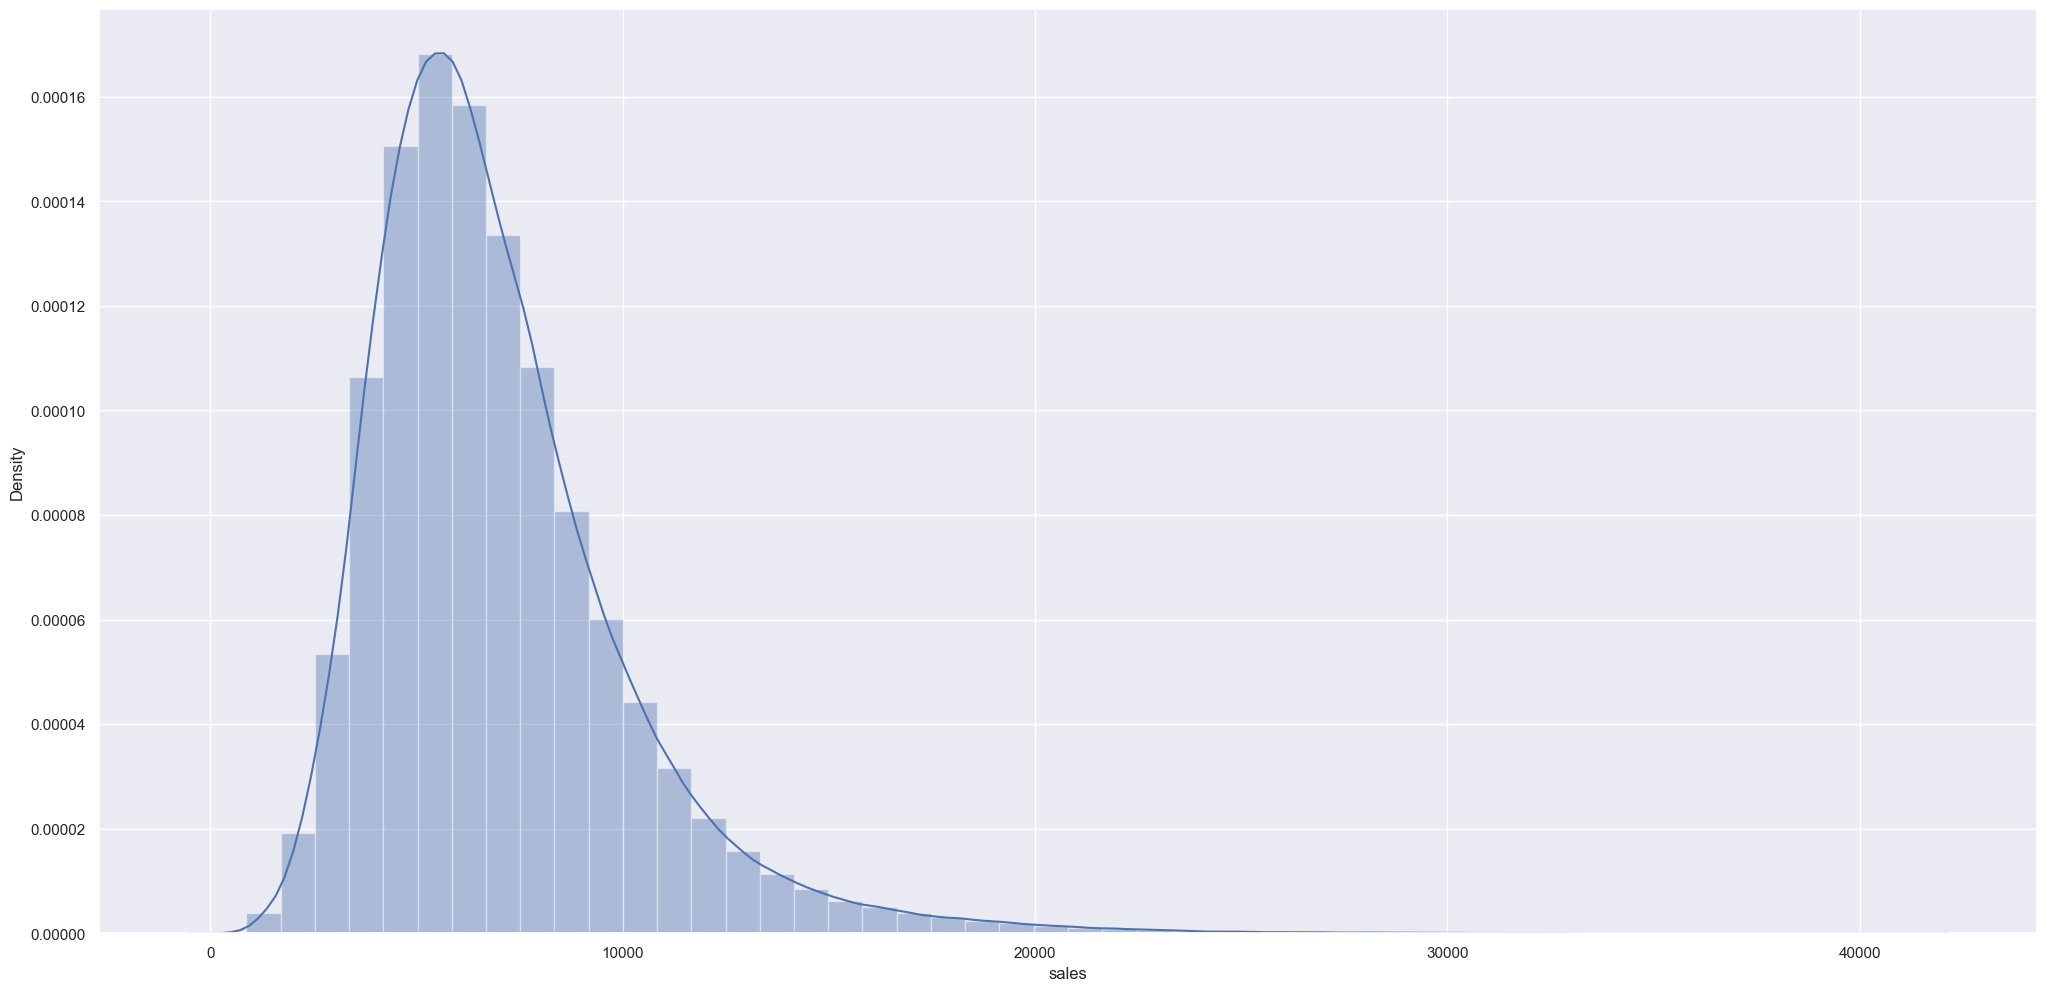

In [51]:
sns.distplot(df4['sales'])

### 5.3.3. Transformações de natureza

In [52]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30) ) )

In [53]:
df5.head()

,store,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,day_of_week,date,sales,promo,school_holiday,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos
0,1,2,1,-0.170968,9,2008,0,31,2015,5,2015-07-31,8.568646,1,1,1.0,7,31,31,2015-30,2008-09-01,-0.170968,2015-07-27,1.0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,2.079117e-01,0.978148
1,1,2,1,-0.170968,9,2008,0,31,2015,4,2015-07-30,8.521384,1,1,1.0,7,30,31,2015-30,2008-09-01,-0.170968,2015-07-27,1.0,0,0,0,1,-0.433884,-0.900969,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.000000
2,1,2,1,-0.170968,9,2008,0,31,2015,3,2015-07-29,8.472823,1,1,1.0,7,29,31,2015-30,2008-09-01,-0.170968,2015-07-27,1.0,0,0,0,1,0.433884,-0.900969,-0.5,-0.866025,-0.568065,-0.822984,-2.079117e-01,0.978148
3,1,2,1,-0.170968,9,2008,0,31,2015,2,2015-07-28,8.519590,1,1,1.0,7,28,31,2015-30,2008-09-01,-0.170968,2015-07-27,1.0,0,0,0,1,0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-4.067366e-01,0.913545
4,1,2,1,-0.170968,9,2008,0,31,2015,1,2015-07-27,8.716536,1,1,1.0,7,27,31,2015-30,2008-09-01,-0.170968,2015-07-27,1.0,0,0,0,1,0.781831,0.623490,-0.5,-0.866025,-0.568065,-0.822984,-5.877853e-01,0.809017


# 6. PASSO 06 - FEATURE SELECTION

- Remover features colineares
- Identificar variáveis relevantes ou não relevantes.
- Relevância: O coeficiente de correlação mede a intensidade da relevância das features.

* Os métodos de seleção de variáveis:
1. Seleção univariada (Filter Methods)
x: variável resposta
y: variável preditora

-- | Contínua | Categórica
--|--|--
Contínua | Correlação de pearson | Linear Discriminant Analysis (LDA)
Categórica | Anova | Chi-Square/ Cramer's V

- Critério: Coeficiente de correlação;
- Vantegens: Método simples, rápido e de fácil entendimento;
- Desvantagem: Não considera a influência entre as variáveis.

2. Seleção por importância ou método embutido (Embedded Methods)
- É um subproduto do aprendizado de outros modelos (random forest, lasso e ridge regression)
- Critério: Peso / importância.
- Vantagem:
- Desvantagem:

3. Seleção por SubSet (Wrapper Methods)
- Critério: Comparação entre resultados de acurácia, utilizando 1 variável por vez (Boruta)
- Desvantagem: Tempo de processamento

In [54]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [55]:
# Remove todas as features que foram derivadas
cols_drop = ['day', 'week_of_year', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df6 =  df6.drop(cols_drop, axis=1)

In [56]:
# Calcula as maior data de venda - 6 semanas
df6[['store', 'date']].groupby('store').max().reset_index().max()[1] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
# training dataset -->> 802,942
X_train = df6[df6['date'] < '2015-06/19']
y_train = X_train['sales']

# test dataset -->> 41,296
X_test = df6[df6['date'] >= '2015-06/19']
y_test = X_test['sales']

print('Training Min Date {}'.format( X_train['date'].min() ))
print('Training Max Date {}'.format( X_train['date'].max() ))

print('\nTest Min Date {}'.format( X_test['date'].min() ))
print('Test Max Date {}'.format( X_test['date'].max() ))

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2. Boruta as feature selector

In [58]:
# training dataset para o Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel() # coloca tudo num vetor

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [59]:
# Ranking de relevância
#cols_selected = boruta.support_.tolist()

# best features selected by Boruta
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected]

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [60]:
#cols_selected_boruta.columns

## 6.3. Manual Feature Selection

In [61]:
cols_selected_boruta = ['store', 'store_type', 'assortment', 'competition_distance',
                        'competition_open_since_month', 'competition_open_since_year', 'promo2',
                        'promo2_since_week', 'promo2_since_year', 'promo',
                        'competition_time_month', 'day_of_week_sin', 'day_of_week_cos',
                        'month_cos', 'week_of_year_cos', 'day_sin', 'day_cos']

# Adicionar colunas
feat_to_add = ['date', 'sales']

# Features final
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7. PASSO 07  - MACHINE LEARNING MODELING

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [63]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns= {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [64]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1879.007982,0.282485,2724.752731


### 7.2.1. Linear Regression Model - Cross Validation

In [65]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2096.92 +/- 331.15,0.29 +/- 0.01,3015.6 +/- 495.91


## 7.3. Linear Regression Regularized Model - Lasso

In [66]:
# Model
lrr = Lasso( alpha= 0.01 ).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression Regularized - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1892.731487,0.290042,2741.026585


### 7.3.1. Lasso - Cross Validation

In [67]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.23 +/- 342.11,0.29 +/- 0.01,3058.18 +/- 504.81


## 7.4. Random Forest Regressor

In [68]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,748.692844,0.109466,1123.657416


### 7.4.1. Random Forest Regressor - Cross Validation

In [69]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,871.03 +/- 191.38,0.12 +/- 0.02,1294.12 +/- 276.77


## 7.5. XGBoost Regressor

In [70]:
# Model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,902.043496,0.134872,1292.711802


### 7.5.1. XGBoost Regressor  - Cross Validation

In [71]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1094.3 +/- 197.98,0.15 +/- 0.02,1563.15 +/- 291.91


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [72]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE').reset_index(drop=True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,748.692844,0.109466,1123.657416
1,XGBoost Regressor,902.043496,0.134872,1292.711802
2,Average Model,1354.800353,0.206400,1835.135542
3,Linear Regression,1879.007982,0.282485,2724.752731
4,Linear Regression Regularized - Lasso,1892.731487,0.290042,2741.026585


### 7.6.2.  Real Performance - Cross Validation

In [73]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV').reset_index(drop=True)

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,871.03 +/- 191.38,0.12 +/- 0.02,1294.12 +/- 276.77
1,XGBoost Regressor,1094.3 +/- 197.98,0.15 +/- 0.02,1563.15 +/- 291.91
2,Linear Regression,2096.92 +/- 331.15,0.29 +/- 0.01,3015.6 +/- 495.91
3,Lasso,2117.23 +/- 342.11,0.29 +/- 0.01,3058.18 +/- 504.81


# 8. PASSO 08  - HYPERPARAMETER FINE TUNING

* Estratégias de fine tuning:
1. Random Search
    - Define valores para cada um dos hiperparâmetros aleatoriamente;
    - Vantagem: rápido e  baixo custo;
    - Desvantagem: pode acabar utilizando os mesmos valores e nunca encontrar o melhor.
2. Grid Search
    - Define todas as combinações possíveis de valores que os hiperparâmetros podem assumir;
    - Vantagem: Define os verdadeiros valores que maximizam o aprendizado do modelo;
    - Desvantagem: MUITO demorado, ALTO custo.
3. Baysian Search
    - Define os valores para os hiperparâmetros seguindo a teoria de Bayes;
    - Vantagem: é um meio termo entre random e grid, pois define os hiperparâmetros baseado em aprendizados passados;
    - Desvantagem: mais complexo que os outros dois, mais rápido que o grid e mais lento que o random.

##  8.1.  Random Search

In [74]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [75]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


In [76]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1101.09 +/- 117.34,0.15 +/- 0.01,1571.58 +/- 166.82
0,XGBoost Regressor,1495.94 +/- 144.56,0.2 +/- 0.01,2159.94 +/- 183.65
0,XGBoost Regressor,859.24 +/- 132.76,0.12 +/- 0.01,1229.53 +/- 200.13
0,XGBoost Regressor,964.32 +/- 112.71,0.14 +/- 0.01,1364.2 +/- 165.73
0,XGBoost Regressor,1495.48 +/- 154.44,0.2 +/- 0.01,2162.36 +/- 196.28


## 8.2. Final Model

In [89]:
param_tuned = {'n_estimators': 2500,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.5,
               'colsample_bytree': 0.9,
               'min_child_weight': 15}

In [90]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,680.025422,0.0994,980.612508


In [91]:
# O modelo está subestimando em 0.5%
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.005205914791729078

# 9. PASSO 09 - ERROR TRANSLATION AND INTERPRETATION

Como entender a performance do modelo e dizer para o CEO o quanto R$ esse modelo vai trazer para a empresa?

1. Performance do modelo de regressão:
    - MAE (Mean Absolute Error);
    - MAPE (Mean Absolute Percentage Error);
    - RMSE (Root Mean Squared Error);
    - MPE (Mean Percentage Error).


2. Performance do modelo sobre o negócio:
    - Comparação com o Status quo (processo utilizado atualmente);
    - Incremento de receita, NPS, de usuários, velocidade etc.

1. Características do Erro MAE:
    - Atribui peso igual para todos os erros;
    - Robusto na presença de outliers;
    - Fácil entendimento pelo time de negócio;
    - Reportar para o negócio.
    
    
2. Características do Erro MAPE:
    - Mostra o quão longe a predição está do valor real, na média, em porcentagem;
    - Muito usado na divulgação de resultados;
    - Não pode ser usado se a variável resposta contém 0;
    - MAE/np.expm1(y_test).mean()
    
    
3. Características do erro RMSE:
    - Atribui MAIOR PESO a erros maiores;
    - Sensível na presença de outliers;
    - Ideal para medir a performance de modelos de ml;
    - Utilizar como parâmetro de melhoria.
    
    
4. Características do erro MPE:
    - Não pode ser usado para medir a performance do modelo;
    - Útil para entender se o modelo está subestimando ou superestimando;
    - Não pode ser usado se a variável resposta contém 0;


1. Performance do modelo de regressão:
    - Métricas para melhoria de performance do modelo;
    - RMSE e MPE.


2. Performance do modelo sobre o negócio:
    - Métricas de report para o time de negócio;
    - MAE, MAPE e MPE.

In [93]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

##  9.1.  Business Performance

In [94]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Cenários
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Ordem das colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [95]:
# Lojas com erros maiores
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106562.023438,103241.744115,109882.302760,3320.279323,0.567365
908,909,243748.156250,236238.766219,251257.546281,7509.390031,0.516141
1085,1086,292133.937500,290103.614443,294164.260557,2030.323057,0.379340
191,192,309917.250000,305104.256994,314730.243006,4812.993006,0.359516
814,815,315472.468750,313299.698928,317645.238572,2172.769822,0.359145


In [96]:
# Lojas com erros menores
df92.sort_values('MAPE').head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
947,948,349457.531250,349043.726619,349871.335881,413.804631,0.048585
258,259,555520.875000,554903.319949,556138.430051,617.555051,0.049138
816,817,757232.250000,756167.599055,758296.900945,1064.650945,0.052198
958,959,256805.890625,256419.150661,257192.630589,386.739964,0.052609
497,498,260821.937500,260440.854558,261203.020442,381.082942,0.053176


<AxesSubplot: xlabel='store', ylabel='MAPE'>

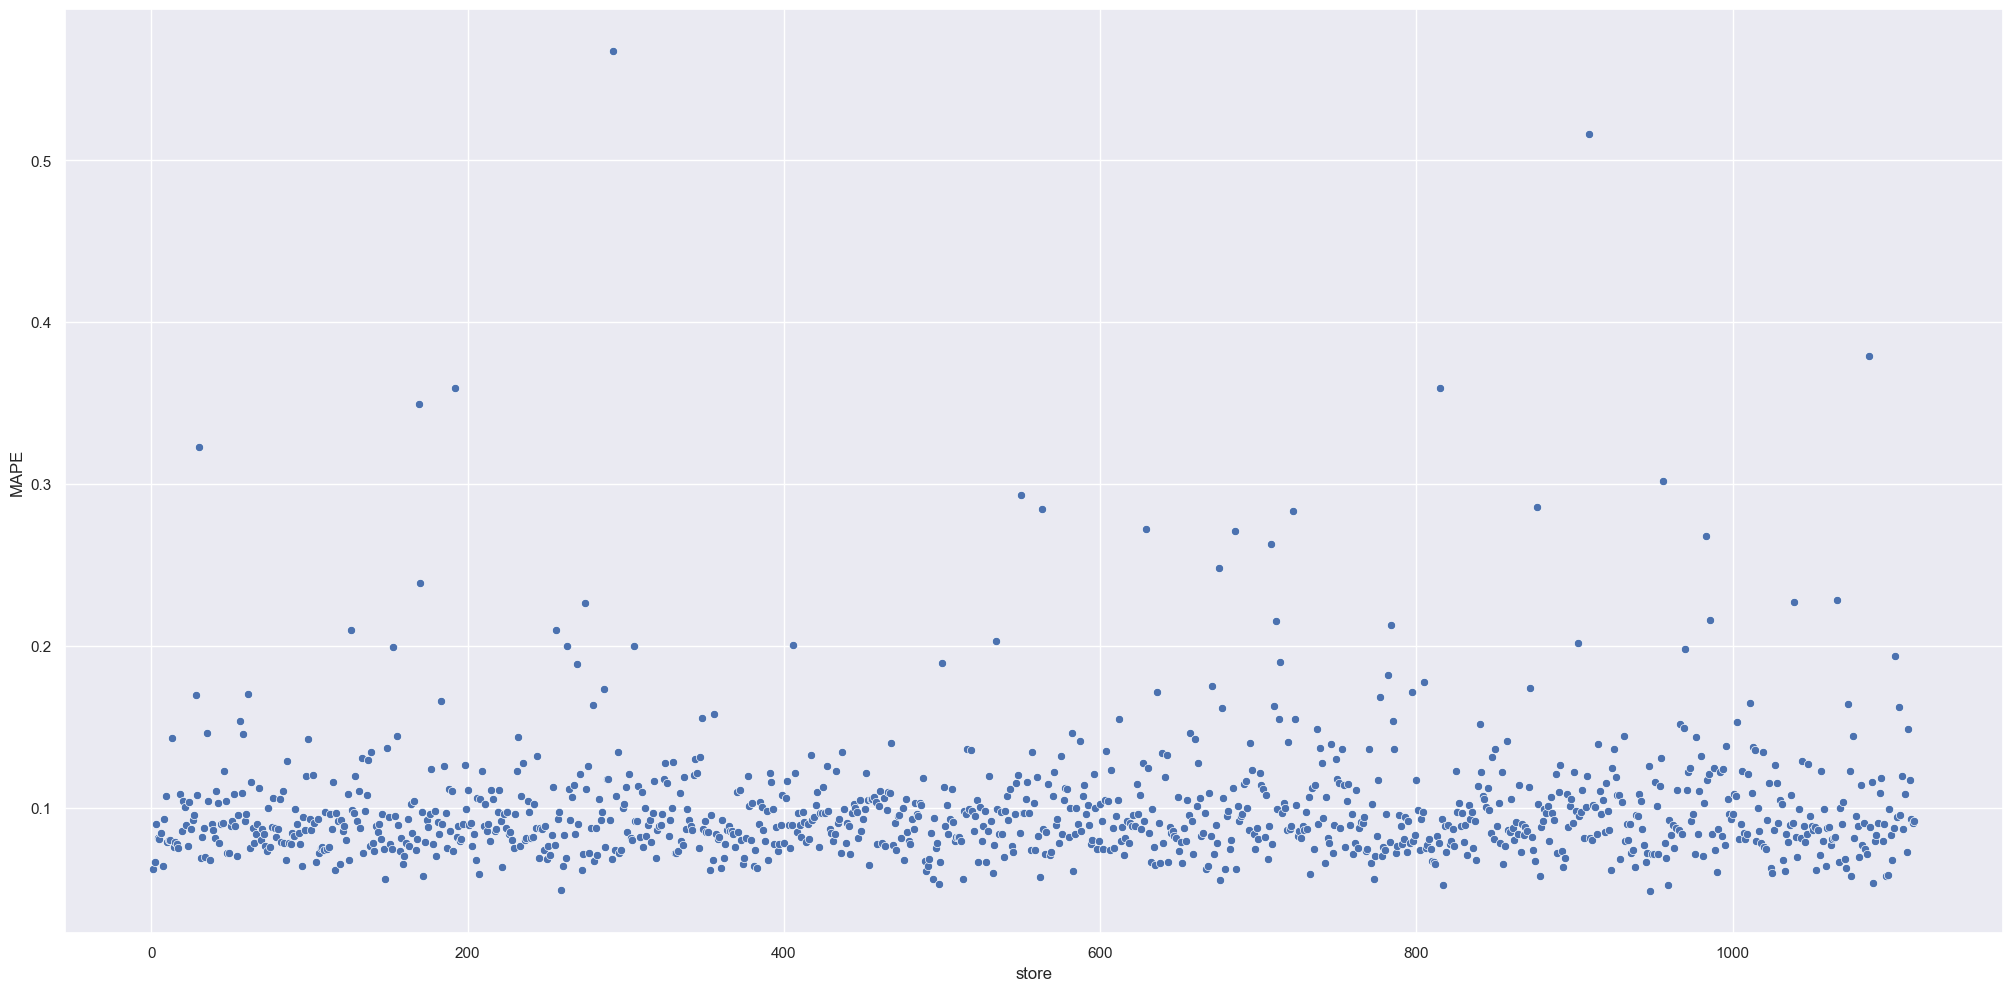

In [97]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. Total Performance

In [98]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R$ {:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$ 284,215,872.00"
1,worst_scenario,"R$ 283,453,104.21"
2,best_scenario,"R$ 284,978,623.45"


## 9.3. Machine Learning Performance

1. Quantidade de vendas ao longo do tempo: O gráfico contém sombras que indicam a incerteza ou variação dos valores da série ao longo do eixo y. Essa sombra é conhecida como "intervalo de confiança" e é frequentemente usado para representar a dispersão dos dados ou a incerteza associada às estimativas. A presença da sombra no gráfico permite ter uma ideia visual da dispersão dos dados ao redor da linha média, fornecendo uma indicação da variabilidade dos valores de vendas em diferentes datas. Quanto maior a sombra, maior a incerteza ou variação associada aos valores de vendas naquele ponto. Nota-se que os dias de maior variância dos preços reais se refletem também na predição.

2. Taxa de erro ao longo do tempo: Sendo error_rate = prediction / sales. Então, o gráfico indica a variação do erro relativo entre as previsões ("predictions") e as vendas reais ("sales") ao longo do tempo. A linha pontilhada é usada para destacar o ponto em que as previsões são exatamente iguais às vendas reais (=1). Qualquer ponto acima dessa linha indica uma superestimação, enquanto qualquer ponto abaixo indica uma subestimação.

3. Distribuição do erro: O gráfico de distribuição permite visualizar como os erros estão distribuídos em relação à média e à variabilidade. Nota-se que o erro está muito próximo da normal, o que é ótimo.

4. Relação entre as previsões e os erros associados a elas: o gráfico fornece informações valiosas em termos de análise de resíduo, ou seja, mostra os pontos fracos do modelo e fala muito sobre o desempenho dele. Nota-se que: a maior parte dos pontos estão concentrados próximo do erro zero, existe uma variância do erro entre +-10.000 mesmo para valores maiores, mas existem alguns outliers acima entre a faixa de predição de 5.000 a 10.000.

In [99]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot: xlabel='predictions', ylabel='error'>

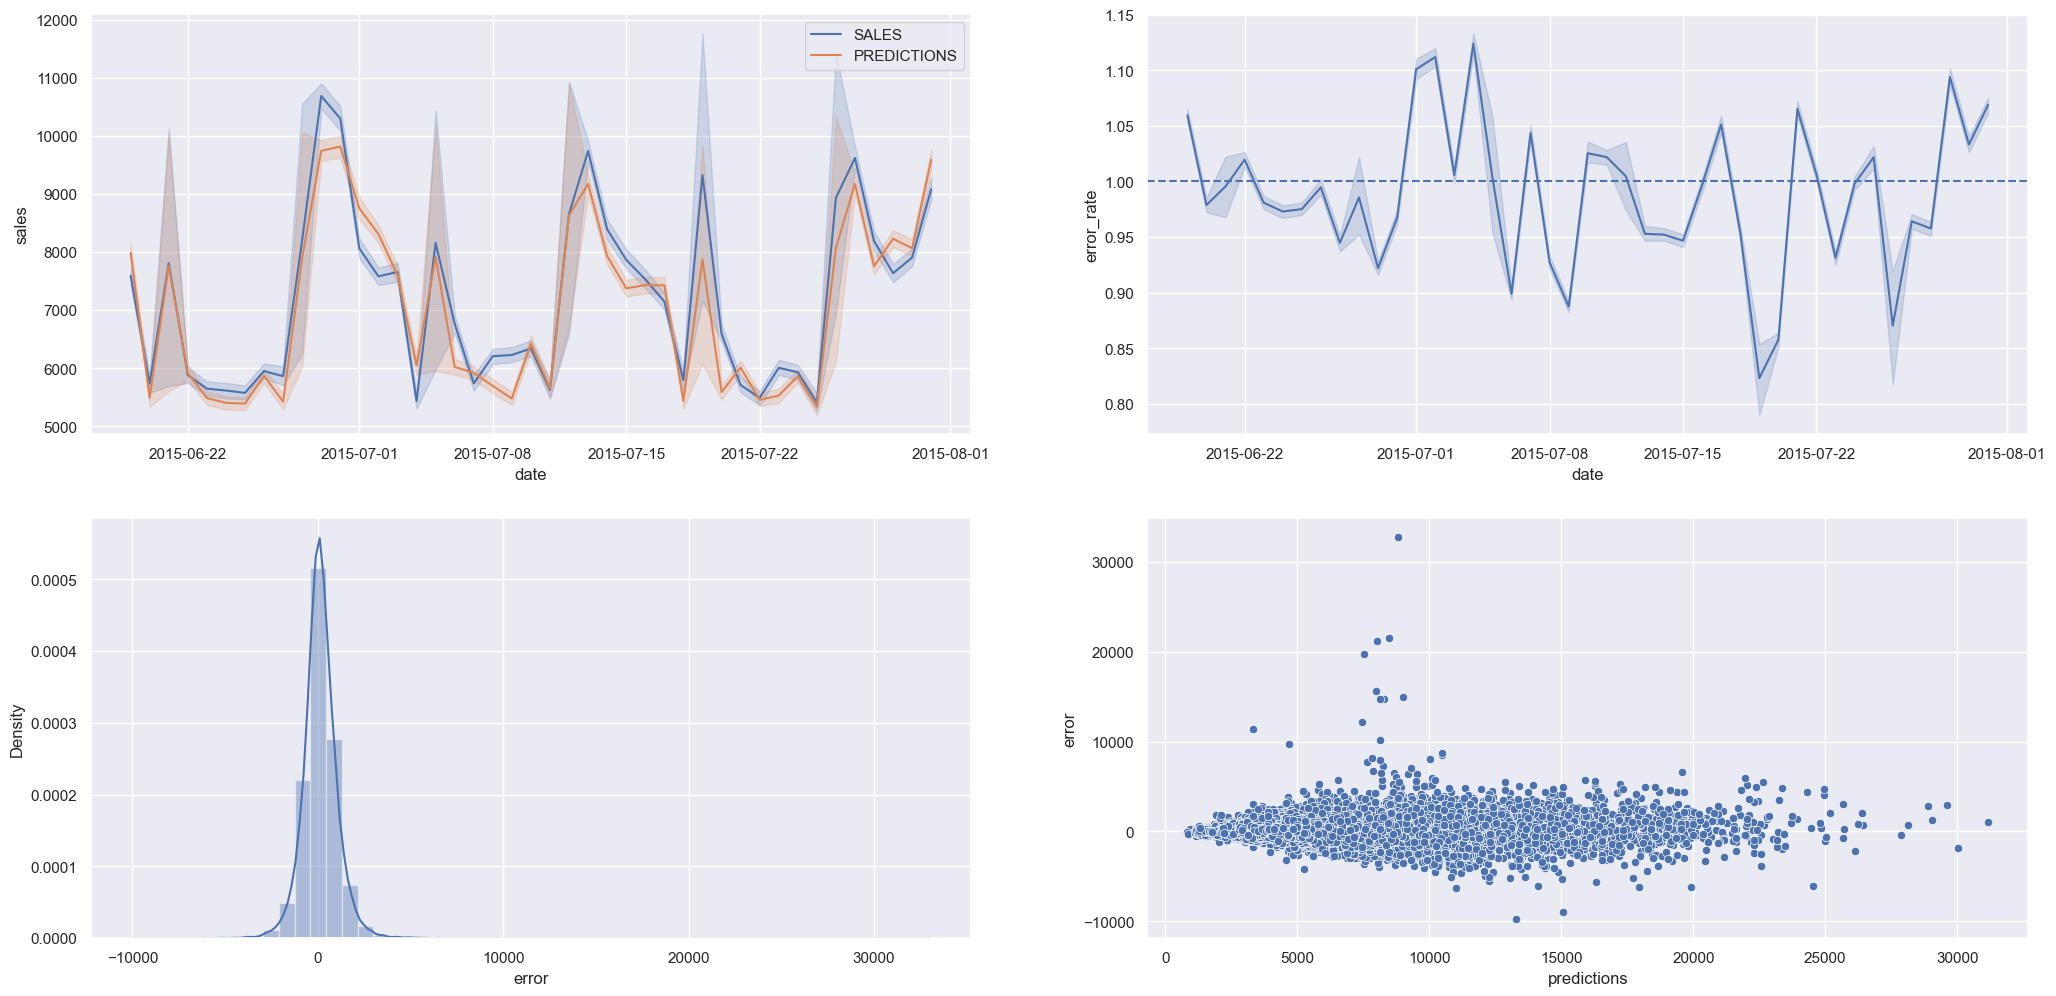

In [102]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9)

# 10. Passo 10 - DEPLOY MODEL PRODUCTION

## 10.1. Rossmann Class

In [ ]:
class Rossmann(object):
    def __init__(self):        
        self.competition_distance_scaler   = pickle.load(open('../parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('../parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo2_time_week_scaler       = pickle.load(open('../parameter/promo2_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('../parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('../parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self, df1):

        ## 1.1. Rename Columns

        df1.columns = rename_columns( df1.columns )

        ## 1.5. Fillout NA's

        # Alterar o tipo 'date' para datetime para usar na função lambda abaixo
        df1['date'] = pd.to_datetime( df1['date'] )

        # 'competition_distance': distância em metros até a loja concorrente mais próxima
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000.0 if math.isnan(x) else x )

        # 'competition_open_since_month': o mês aproximado da hora em que o concorrente mais próximo foi aberto
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                         if math.isnan(x['competition_open_since_month']) 
                                                         else x['competition_open_since_month'], axis=1 )

        # 'competition_open_since_year': o ano aproximado da hora em que o concorrente mais próximo foi aberto
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                                        if math.isnan(x['competition_open_since_year']) 
                                                        else x['competition_open_since_year'], axis=1 )

        # 'promo2_since_week': descreve a semana do calendário em que a loja começou a participar do Promo2
        df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week
                                               if math.isnan(x['promo2_since_week'])
                                               else x['promo2_since_week'], axis=1 ) 

        # 'promo2_since_year': descreve o ano em que a loja começou a participar do Promo2
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year
                                              if math.isnan(x['promo2_since_year'])
                                              else x['promo2_since_year'], axis=1)

        # 'promo_interval': descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente.
        df1['promo_interval'].fillna( 0, inplace=True )

        ## 1.6. Change Data Types

        # Alterar os tipos de float para int
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
        
        ### 2.4.1. Converter

        # Converter os códigos de 'state_holiday' em nome (a: public_holiday, b: easter_holiday, c: christmas, 0: regular_day)
        state_holiday_rename = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'}
        df2['state_holiday'] = df2['state_holiday'].map(state_holiday_rename)

        # Converter os códigos de 'assortment' em nível de variedades de produtos (a: basic, b: extra, c: extended)
        assortment_rename = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
        df2['assortment'] = df2['assortment'].map(assortment_rename)

        ### 2.4.2. Criar

        # 'year': ano de venda
        df2['year'] = df2['date'].dt.year

        # 'month': mês de venda
        df2['month'] = df2['date'].dt.month

        # 'day': day de venda
        df2['day'] = df2['date'].dt.day

        # 'week_of_year': semana de venda do ano
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # 'year_week': semana de venda do ano, no formato string 'YYYY-WW'
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # 'competition_time_month': Quantidade de meses desde que a concorrência abriu até a data de venda
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                           month=x['competition_open_since_month'],
                                                                           day=1 ), axis=1 )
        df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30 ).apply( lambda x: x.days ).astype( int )

        # promo2_since: Data de início da promo2
        df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

        # promo2_time_week: Quantidade de semanas desde o início da promo2 até a data de venda
        df2['promo2_time_week'] = ( ( df2['date'] - df2['promo2_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # 3. PASSO 03 - FILTRAGEM DE VARIÁVEIS

        ## 3.1. Filtragem das Linhas

        # Filtrar apenas lojas abertas e com vendas
        df2 = df2.loc[( df2['open'] != 0 ) & ( df2['sales'] > 0 ), :].reset_index(drop=True)

        ## 3.2. Seleção das Colunas

        # Remover colunas que não serão utilizadas
        cols_drop = ['customers', 'open', 'promo_interval']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation(self, df5):
        
        ## 5.2. Rescaling
        # 'competition_distance'
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # 'competition_time_month'
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_distance']].values)

        # 'promo2_time_week'
        df5['promo2_time_week'] = self.promo2_time_week_scaler.fit_transform(df5[['year']].values)

        # 'year'
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3. Transformação

        ### 5.3.1. Encoding

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        ### 5.3.3. Transformações de natureza

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12) ) )

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30) ) )
        
        cols_selected = ['store', 'store_type', 'assortment', 'competition_distance',
                        'competition_open_since_month', 'competition_open_since_year', 'promo2',
                        'promo2_since_week', 'promo2_since_year', 'promo',
                        'competition_time_month', 'day_of_week_sin', 'day_of_week_cos',
                        'month_cos', 'week_of_year_cos', 'day_sin', 'day_cos']
        
        return df5[cols_selected]

## 10.2. API Handler

## 10.3. API Tester